# Predcition of Hospital Admission Related to Upper Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to upper respiratory tract infection (urti).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'urti_date_'+str(i), 'urti_ab_date_'+str(i), 'urti_ab_type_'+str(i),
                   'incdt_urti_date_'+str(i), 'admitted_urti_date_'+str(i), 'sgss_gp_cov_urti_date_'+str(i)]]
    
    #drop rows with no urti reord
    datum = datum[datum['urti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with urti_i
    datum = datum[datum['sgss_gp_cov_urti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'urti_date_'+str(i): 'urti_date', 'urti_ab_date_'+str(i): 'urti_ab_date', 
                           'urti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_urti_date_'+str(i): 'incdt_urti_date', 'incdt_urti_type_'+str(i): 'incdt_urti_type',
                           'admitted_urti_date_'+str(i): 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_'+str(i): 'sgss_gp_cov_urti_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + urti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [18]:
#build cox models stratified with antibiotics history categories
def cox_model_strat_ab_hist_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + urti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [19]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_urti.csv.gz')

In [20]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [21]:
#process 20 urtis and concatenate them 
data_urti_1 = proc_infec_data(data,1)
data_urti_2 = proc_infec_data(data,2)
data_urti_3 = proc_infec_data(data,3)
data_urti_4 = proc_infec_data(data,4)
data_urti_5 = proc_infec_data(data,5)
data_urti_6 = proc_infec_data(data,6)
data_urti_7 = proc_infec_data(data,7)
data_urti_8 = proc_infec_data(data,8)
data_urti_9 = proc_infec_data(data,9)
data_urti_10 = proc_infec_data(data,10)
data_urti_11 = proc_infec_data(data,11)
data_urti_12 = proc_infec_data(data,12)
data_urti_13 = proc_infec_data(data,13)
data_urti_14 = proc_infec_data(data,14)
data_urti_15 = proc_infec_data(data,15)
data_urti_16 = proc_infec_data(data,16)
data_urti_17 = proc_infec_data(data,17)
data_urti_18 = proc_infec_data(data,18)
data_urti_19 = proc_infec_data(data,19)
data_urti_20 = proc_infec_data(data,20)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4, data_urti_5, data_urti_6, data_urti_7, data_urti_8, data_urti_9, data_urti_10, data_urti_11, data_urti_12, data_urti_13, data_urti_14, data_urti_15, data_urti_16, data_urti_17, data_urti_18, data_urti_19, data_urti_20])
data_urti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [22]:
##add variable season
#convert data types
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['urti_date'] 
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_urti with today's date in year and month
data_urti = data_urti[data_urti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_urti = data_urti[data_urti['date'] != last_1_month_date_y_m]
data_urti = data_urti[data_urti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_urti['season'] = np.select(conditions, choices, default='winter')

In [23]:
#add variable time period
data_urti.loc[(data_urti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_urti.loc[((data_urti['date'] >= '2020-01') & (data_urti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_urti.loc[(data_urti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [24]:
#scenario 1
#not hosped (nothing happened)
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0

In [25]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1

#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]

In [26]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0

#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [27]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30

#give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [28]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [29]:
#drop anybody with age less than 18 or 0!
data_urti = data_urti[~(data_urti['age'] < 18)] 
data_urti['age'][data_urti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_urti = data_urti[data_urti['age_cat'] != '0-4']
data_urti = data_urti[data_urti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_urti['bmi'][data_urti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_urti['bmi'] = data_urti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_urti['antibacterial_brit'][data_urti['antibacterial_brit'] < 0] = np.nan

In [30]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"smoking_status": dict_smoking})

In [31]:
#drop rows with missing region
if ('region' in data_urti.columns) and (data_urti['region'].isnull().sum() > 0):
   data_urti = data_urti[data_urti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_urti.columns) and (data_urti['antibacterial_brit'].isnull().sum() > 0):
    data_urti['antibacterial_brit'] = data_urti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_urti.columns) and (data_urti['ethnicity'].isnull().sum() > 0):
    data_urti['ethnicity'] = data_urti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_urti.columns) and (data_urti['smoking_status'].isnull().sum() > 0):
    data_urti['smoking_status'] = data_urti['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_urti.columns) and (data_urti['imd'].isnull().sum() > 0):
    data_urti['imd'] = data_urti['imd'].fillna(0)

In [32]:
#missing values of bmi assign 5 and 0; categorise bmi
data_urti['bmi_cat'] = 5

for idx, x in enumerate(data_urti['bmi_cat']):
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 30:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 25) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 30):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] >= 18.5) and (data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 25):
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_urti.iat[idx, data_urti.columns.get_loc('bmi')] < 18.5:
        data_urti.iat[idx, data_urti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_urti.columns) and (data_urti['bmi_cat'].isnull().sum() > 0):
    data_urti['bmi_cat'] = data_urti['bmi_cat'].fillna(0)

In [33]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_urti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_urti['ab_type_cat'] = np.where(data_urti['ab_type'].isin(ab_series[mask].index),'other',data_urti['ab_type'])
#assign no to non ab users
data_urti.loc[data_urti['urti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_urti['ab_type_cat'] = data_urti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [34]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_urti = data_urti.replace({"sex": dict_sex})
data_urti = data_urti.replace({"ethnicity": dict_ethnicity})
data_urti = data_urti.replace({"smoking_status": dict_smoking})
data_urti = data_urti.replace({"imd": dict_imd})
data_urti = data_urti.replace({"bmi_cat": dict_bmi})
data_urti = data_urti.replace({"flu_vaccine": dict_flu})
data_urti = data_urti.replace({"region": dict_region})
data_urti = data_urti.replace({"age_cat": dict_age})
data_urti = data_urti.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [35]:
#categorise CCI
data_urti['CCI_cat'] = pd.cut(data_urti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_urti['antibacterial_brit'].clip(0, data_urti['antibacterial_brit'].quantile(0.95), inplace=True)
#categorise antibiotic hisotry
data_urti['antibacterial_brit_cat'] = pd.cut(data_urti['antibacterial_brit'], right=False, bins=[0,1,2,5,10000], labels=['none0', 'low1', 'medium2_4', 'high5_more'])
data_urti['antibacterial_brit_cat'].value_counts()

none0         90734
medium2_4     75068
low1          12005
high5_more        0
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

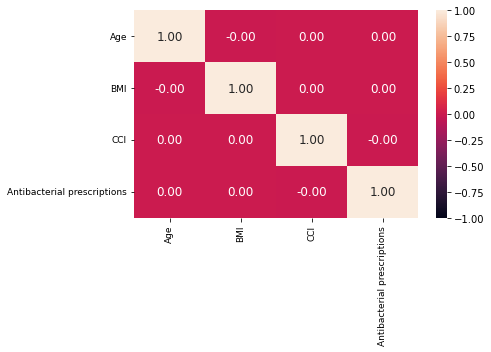

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_urti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_urti/corr_urti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [37]:
data_urti = data_urti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'antibacterial_brit_cat', 'urti_ab_date', 'ab_type_cat', 'incdt_urti_date', 'date', 'period',
                                   'event_urti_admitted', 'duration_urti_admitted'
                                    ]]

In [38]:
#incident and prevalent infection 
data_urti_incdt = data_urti[data_urti['incdt_urti_date'] == 0]
data_urti_prevl = data_urti[data_urti['incdt_urti_date'] == 1]
#switch variable urti_ab_date into a binary variable
data_urti_incdt[['urti_ab_date']] = data_urti_incdt[['urti_ab_date']].where(data_urti_incdt[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_urti_prevl[['urti_ab_date']] = data_urti_prevl[['urti_ab_date']].where(data_urti_prevl[['urti_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_urti_incdt_males = data_urti_incdt[data_urti_incdt['sex'] == 'male']
data_urti_incdt_females = data_urti_incdt[data_urti_incdt['sex'] == 'female']
data_urti_prevl_males = data_urti_prevl[data_urti_prevl['sex'] == 'male']
data_urti_prevl_females = data_urti_prevl[data_urti_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_urti_incdt_15_24 = data_urti_incdt[data_urti_incdt['age_cat'] == '15_24']
data_urti_incdt_25_34 = data_urti_incdt[data_urti_incdt['age_cat'] == '25_34']
data_urti_incdt_35_44 = data_urti_incdt[data_urti_incdt['age_cat'] == '35_44']
data_urti_incdt_45_54 = data_urti_incdt[data_urti_incdt['age_cat'] == '45_54']
data_urti_incdt_55_64 = data_urti_incdt[data_urti_incdt['age_cat'] == '55_64']
data_urti_incdt_65_74 = data_urti_incdt[data_urti_incdt['age_cat'] == '65_74']
data_urti_incdt_75_more = data_urti_incdt[data_urti_incdt['age_cat'] == '75_more']
data_urti_prevl_15_24 = data_urti_prevl[data_urti_prevl['age_cat'] == '15_24']
data_urti_prevl_25_34 = data_urti_prevl[data_urti_prevl['age_cat'] == '25_34']
data_urti_prevl_35_44 = data_urti_prevl[data_urti_prevl['age_cat'] == '35_44']
data_urti_prevl_45_54 = data_urti_prevl[data_urti_prevl['age_cat'] == '45_54']
data_urti_prevl_55_64 = data_urti_prevl[data_urti_prevl['age_cat'] == '55_64']
data_urti_prevl_65_74 = data_urti_prevl[data_urti_prevl['age_cat'] == '65_74']
data_urti_prevl_75_more = data_urti_prevl[data_urti_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_urti_incdt_prepandemic = data_urti_incdt[data_urti_incdt['date'] <= '2019-12']
data_urti_incdt_during_pandemic = data_urti_incdt[(data_urti_incdt['date'] >= '2020-03') & (data_urti_incdt['date']<= '2021-03')]
data_urti_incdt_post_2nd_lockdown = data_urti_incdt[data_urti_incdt['date'] <= '2021-04']
data_urti_prevl_prepandemic = data_urti_prevl[data_urti_prevl['date'] <= '2019-12']
data_urti_prevl_during_pandemic = data_urti_prevl[(data_urti_prevl['date'] >= '2020-03') & (data_urti_prevl['date']<= '2021-03')]
data_urti_prevl_post_2nd_lockdown = data_urti_prevl[data_urti_prevl['date'] <= '2021-04']

#incident and prevalent infection stratified by antibiotics history categories
data_urti_incdt_none0 = data_urti_incdt[data_urti_incdt['antibacterial_brit_cat'] == 'none0']
data_urti_incdt_low1 = data_urti_incdt[data_urti_incdt['antibacterial_brit_cat'] == 'low1']
data_urti_incdt_medium2_4 = data_urti_incdt[data_urti_incdt['antibacterial_brit_cat'] == 'medium2_4']
data_urti_incdt_high5_more = data_urti_incdt[data_urti_incdt['antibacterial_brit_cat'] == 'high5_more']
data_urti_prevl_none0 = data_urti_prevl[data_urti_prevl['antibacterial_brit_cat'] == 'none0']
data_urti_prevl_low1 = data_urti_prevl[data_urti_prevl['antibacterial_brit_cat'] == 'low1']
data_urti_prevl_medium2_4 = data_urti_prevl[data_urti_prevl['antibacterial_brit_cat'] == 'medium2_4']
data_urti_prevl_high5_more = data_urti_prevl[data_urti_prevl['antibacterial_brit_cat'] == 'high5_more']

# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['urti_ab_date'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['urti_ab_date'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['urti_ab_date'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['urti_ab_date'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

In [39]:
#store data for plotting hosp admission counts and percentages
%store data_urti
# save data
data_urti.to_csv('../output/hospitalisation_prediction_urti/data_urti.csv')

Stored 'data_urti' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident urti with no antibiotics

<lifelines.CoxPHFitter: fitted with 108185 total observations, 107487 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 108185
number of events observed = 698
   partial log-likelihood = -8070.17
         time fit was run = 2023-06-21 16:58:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.11            -0.26             0.19                 0.77                 1.21
CCI_cat[T.medium]                0.17       1.19       0.12            -0.06             0.41                 0.94                 1.51
CCI_cat[T.high]                 -0.08       0.93       0.15            -0.37             0.22                 0.69                 1.25
CCI_cat[T.very_high]            -0.08       0.92       0.13            -0.34             0.18                 0.71                 1.20
age_cat[T.25_34]                -0.04       0.96       0.14            -0.31             0.24                 0.73                 1.27
age_cat[T.35_44]                -0.05       0.95       0.14            -0.33             0.23                 0.72                 1.25
age_cat[T.45_54]                -0.09       0.92       0.14            -0.37             0.19                 0.69                 1.21
age_cat[T.55_64]                 0.09       1.09       0.14            -0.18             0.36                 0.84                 1.43
age_cat[T.65_74]                 0.03       1.03       0.14            -0.25             0.30                 0.78                 1.35
age_cat[T.75_more]              -0.09       0.91       0.14            -0.38             0.19                 0.69                 1.21
antibacterial_brit               0.01       1.01       0.03            -0.04             0.06                 0.96                 1.06
bmi_cat[T.obese]                 0.04       1.04       0.14            -0.25             0.32                 0.78                 1.37
bmi_cat[T.overweight]           -0.09       0.92       0.18            -0.44             0.26                 0.65                 1.30
bmi_cat[T.underweight]           0.30       1.34       0.23            -0.15             0.74                 0.86                 2.10
bmi_cat[T.unknown]              -0.04       0.97       0.15            -0.34             0.27                 0.71                 1.31
ethnicity[T.unknown]            -0.20       0.82       0.12            -0.45             0.04                 0.64                 1.04
ethnicity[T.white]              -0.04       0.96       0.11            -0.25             0.17                 0.78                 1.18
flu_vaccine[T.yes]               0.05       1.05       0.12            -0.19             0.29                 0.82                 1.34
imd[T.medium]                    0.08       1.08       0.12            -0.16             0.31                 0.85                 1.36
imd[T.unaffluent]               -0.07       0.93       0.12            -0.31             0.17                 0.73                 1.19
imd[T.unknown]                   0.14       1.15       0.18            -0.21             0.49                 0.81                 1.64
imd[T.very_affluent]            -0.03       0.97       0.12            -0.27             0.21                 0.77                 1.24
imd[T.very_unaffluent]          -0.17       0.84       0.13            -0.42             0.08                 0.66                 1.08
region[T.east_midlands]         -0.30       0.74       0.17            -0.63             0.04                 0.53                 1.04
region[T.london]                -0.19       0.83       0.14      

12787


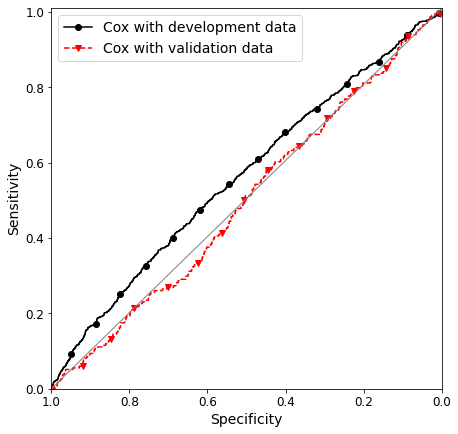

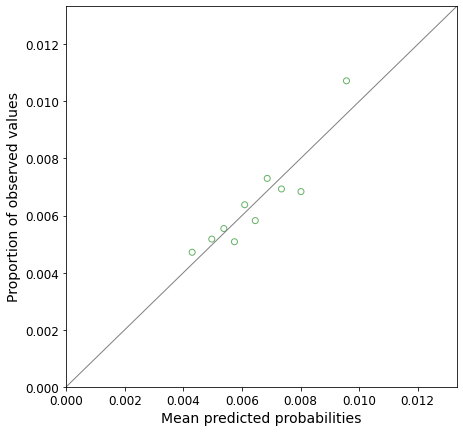

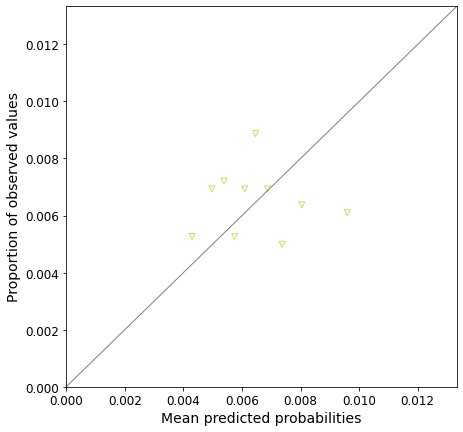

In [40]:
#data prep
data, data_urti_no_abs_incdt_enc = cox_data_prep(data_urti_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'no_abs_incdt', data_urti_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'no_abs_incdt', data_urti_no_abs_incdt)

try:
    #build cox model 
    cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test = cox_model_build('urti', 'no_abs_incdt', data_urti_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_no_abs_incdt, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_no_abs_incdt.csv', data_urti_no_abs_incdt_enc, data_urti_no_abs_incdt, 'sum_betas_cph_urti_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_no_abs_incdt, 'event_urti_admitted', data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, 'event_urti_admitted', data_urti_no_abs_incdt_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_no_abs_incdt_train.jpg', 'calibration_cph_urti_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_no_abs_incdt, 'urti', 'no_abs_incdt', data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident urti with antibiotics

<lifelines.CoxPHFitter: fitted with 11976 total observations, 11921 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 11976
number of events observed = 55
   partial log-likelihood = -501.15
         time fit was run = 2023-06-21 16:58:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.44       0.64       0.38            -1.18             0.30                 0.31                 1.35
CCI_cat[T.medium]               -0.66       0.52       0.46            -1.55             0.24                 0.21                 1.27
CCI_cat[T.high]                  0.10       1.11       0.44            -0.76             0.97                 0.47                 2.64
CCI_cat[T.very_high]            -0.31       0.73       0.44            -1.18             0.56                 0.31                 1.74
age_cat[T.25_34]                 0.25       1.28       0.48            -0.69             1.18                 0.50                 3.25
age_cat[T.35_44]                -0.15       0.86       0.52            -1.17             0.87                 0.31                 2.38
age_cat[T.45_54]                -0.21       0.81       0.54            -1.27             0.85                 0.28                 2.34
age_cat[T.55_64]                 0.05       1.06       0.50            -0.93             1.04                 0.40                 2.82
age_cat[T.65_74]                 0.32       1.38       0.47            -0.59             1.24                 0.56                 3.45
age_cat[T.75_more]              -0.42       0.66       0.57            -1.54             0.70                 0.22                 2.02
antibacterial_brit              -0.04       0.96       0.10            -0.23             0.15                 0.79                 1.16
bmi_cat[T.obese]                -0.52       0.59       0.43            -1.36             0.31                 0.26                 1.37
bmi_cat[T.overweight]           -0.45       0.64       0.56            -1.54             0.65                 0.21                 1.91
bmi_cat[T.underweight]           0.34       1.40       0.63            -0.90             1.57                 0.41                 4.81
bmi_cat[T.unknown]              -0.63       0.53       0.48            -1.56             0.31                 0.21                 1.36
ethnicity[T.unknown]             0.03       1.03       0.48            -0.91             0.96                 0.40                 2.62
ethnicity[T.white]               0.21       1.23       0.41            -0.60             1.02                 0.55                 2.77
flu_vaccine[T.yes]               0.53       1.71       0.37            -0.18             1.25                 0.83                 3.49
imd[T.medium]                   -0.00       1.00       0.43            -0.84             0.83                 0.43                 2.30
imd[T.unaffluent]                0.17       1.19       0.42            -0.65             0.99                 0.52                 2.70
imd[T.unknown]                  -1.13       0.32       1.05            -3.18             0.92                 0.04                 2.50
imd[T.very_affluent]            -0.04       0.96       0.44            -0.90             0.81                 0.41                 2.26
imd[T.very_unaffluent]          -0.06       0.94       0.44            -0.92             0.79                 0.40                 2.21
region[T.east_midlands]          0.20       1.22       0.56            -0.90             1.29                 0.41                 3.63
region[T.london]                -0.52       0.59       0.56           

12765


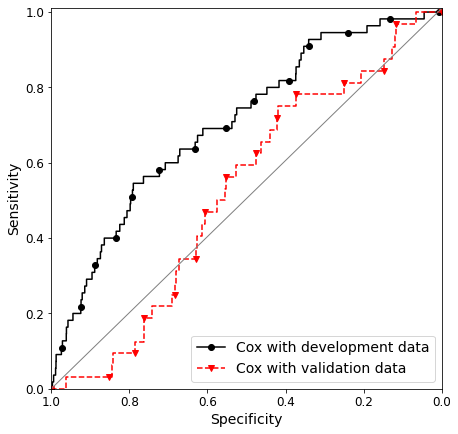

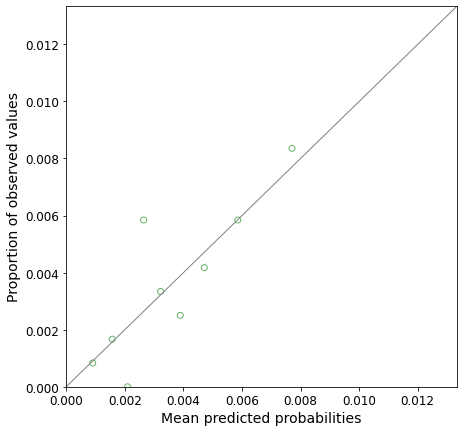

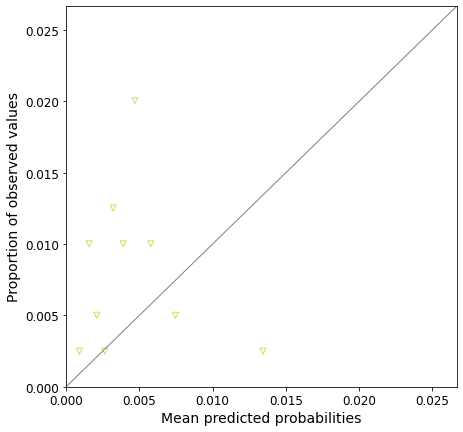

In [41]:
#data prep
data, data_urti_abs_incdt_enc = cox_data_prep(data_urti_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'abs_incdt', data_urti_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'abs_incdt', data_urti_abs_incdt)

try:
    #build cox model 
    cph_urti_abs_incdt, data_urti_abs_incdt_train, data_urti_abs_incdt_test = cox_model_build('urti', 'abs_incdt', data_urti_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_abs_incdt, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_abs_incdt.csv', data_urti_abs_incdt_enc, data_urti_abs_incdt, 'sum_betas_cph_urti_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_abs_incdt, 'event_urti_admitted', data_urti_abs_incdt_train, data_urti_abs_incdt_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, 'event_urti_admitted', data_urti_abs_incdt_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_abs_incdt_train.jpg', 'calibration_cph_urti_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_abs_incdt, 'urti', 'abs_incdt', data_urti_abs_incdt_train, data_urti_abs_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent urti with no antibiotics

<lifelines.CoxPHFitter: fitted with 11835 total observations, 11764 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 11835
number of events observed = 71
   partial log-likelihood = -652.80
         time fit was run = 2023-06-21 16:59:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.16       1.17       0.37            -0.58             0.89                 0.56                 2.44
CCI_cat[T.medium]                0.11       1.12       0.41            -0.70             0.92                 0.50                 2.52
CCI_cat[T.high]                  0.06       1.06       0.49            -0.91             1.03                 0.40                 2.80
CCI_cat[T.very_high]             0.45       1.57       0.41            -0.35             1.25                 0.70                 3.49
age_cat[T.25_34]                 0.29       1.34       0.40            -0.50             1.09                 0.61                 2.96
age_cat[T.35_44]                -0.19       0.83       0.45            -1.07             0.69                 0.34                 1.99
age_cat[T.45_54]                -0.51       0.60       0.48            -1.46             0.44                 0.23                 1.56
age_cat[T.55_64]                -0.09       0.92       0.44            -0.94             0.77                 0.39                 2.16
age_cat[T.65_74]                -0.12       0.89       0.44            -0.98             0.74                 0.38                 2.09
age_cat[T.75_more]              -0.12       0.89       0.44            -0.98             0.74                 0.38                 2.09
antibacterial_brit               0.07       1.07       0.08            -0.09             0.23                 0.92                 1.26
bmi_cat[T.obese]                 1.19       3.29       0.73            -0.23             2.61                 0.80                13.64
bmi_cat[T.overweight]            1.31       3.72       0.78            -0.21             2.83                 0.81                16.98
bmi_cat[T.underweight]           1.02       2.78       1.00            -0.94             2.99                 0.39                19.81
bmi_cat[T.unknown]               1.04       2.84       0.75            -0.42             2.51                 0.65                12.29
ethnicity[T.unknown]            -0.06       0.94       0.39            -0.82             0.70                 0.44                 2.01
ethnicity[T.white]               0.00       1.00       0.34            -0.66             0.67                 0.52                 1.95
flu_vaccine[T.yes]              -0.66       0.52       0.52            -1.67             0.35                 0.19                 1.42
imd[T.medium]                    0.56       1.74       0.41            -0.25             1.37                 0.78                 3.92
imd[T.unaffluent]                0.53       1.69       0.42            -0.29             1.35                 0.75                 3.84
imd[T.unknown]                   0.50       1.66       0.60            -0.68             1.69                 0.51                 5.39
imd[T.very_affluent]             0.07       1.08       0.46            -0.83             0.98                 0.44                 2.65
imd[T.very_unaffluent]           0.45       1.57       0.42            -0.38             1.28                 0.69                 3.59
region[T.east_midlands]          0.64       1.89       0.61            -0.56             1.84                 0.57                 6.28
region[T.london]                 0.71       2.04       0.56           

12749


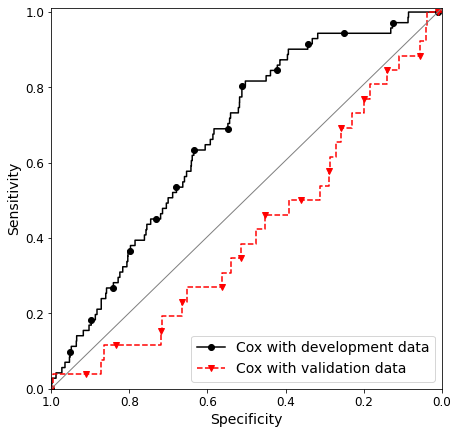

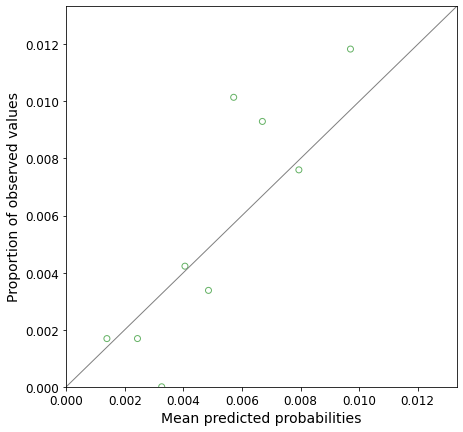

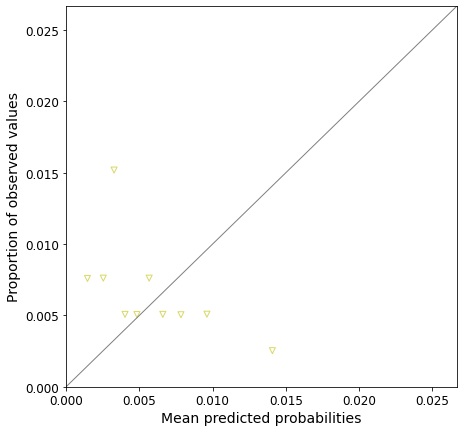

In [42]:
#data prep
data, data_urti_no_abs_prevl_enc = cox_data_prep(data_urti_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'no_abs_prevl', data_urti_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'no_abs_prevl', data_urti_no_abs_prevl)

try:
    #build cox model 
    cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test = cox_model_build('urti', 'no_abs_prevl', data_urti_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_no_abs_prevl, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_no_abs_prevl.csv', data_urti_no_abs_prevl_enc, data_urti_no_abs_prevl, 'sum_betas_cph_urti_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_no_abs_prevl, 'event_urti_admitted', data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, 'event_urti_admitted', data_urti_no_abs_prevl_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_no_abs_prevl_train.jpg', 'calibration_cph_urti_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_no_abs_prevl, 'urti', 'no_abs_prevl', data_urti_no_abs_prevl_train, data_urti_no_abs_prevl_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent urti with antibiotics

<lifelines.CoxPHFitter: fitted with 1359 total observations, 1344 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1359
number of events observed = 15
   partial log-likelihood = -92.34
         time fit was run = 2023-06-21 16:59:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.08       0.34       0.86            -2.77             0.60                 0.06                 1.83
CCI_cat[T.medium]                0.11       1.11       0.76            -1.38             1.59                 0.25                 4.92
CCI_cat[T.high]                 -0.14       0.87       0.96            -2.02             1.74                 0.13                 5.70
CCI_cat[T.very_high]            -0.41       0.66       0.94            -2.25             1.43                 0.11                 4.18
age_cat[T.25_34]                 0.12       1.13       1.45            -2.72             2.96                 0.07                19.39
age_cat[T.35_44]                 0.04       1.05       1.44            -2.77             2.86                 0.06                17.48
age_cat[T.45_54]                 0.83       2.30       1.25            -1.62             3.29                 0.20                26.77
age_cat[T.55_64]                 0.69       1.99       1.26            -1.78             3.16                 0.17                23.51
age_cat[T.65_74]                 1.64       5.15       1.16            -0.63             3.91                 0.53                49.79
age_cat[T.75_more]               1.27       3.56       1.15            -0.98             3.52                 0.38                33.79
antibacterial_brit              -0.11       0.90       0.20            -0.49             0.27                 0.61                 1.32
bmi_cat[T.obese]                 0.05       1.05       1.11            -2.13             2.23                 0.12                 9.31
bmi_cat[T.overweight]            1.02       2.76       1.15            -1.24             3.28                 0.29                26.45
bmi_cat[T.underweight]         -18.09       0.00   11697.25        -22944.27         22908.09                 0.00                  inf
bmi_cat[T.unknown]               0.27       1.31       1.16            -2.00             2.55                 0.14                12.75
ethnicity[T.unknown]            -1.05       0.35       0.96            -2.93             0.83                 0.05                 2.30
ethnicity[T.white]              -0.15       0.86       0.68            -1.49             1.18                 0.22                 3.27
flu_vaccine[T.yes]              -0.80       0.45       1.09            -2.93             1.33                 0.05                 3.79
imd[T.medium]                   -1.03       0.36       0.90            -2.79             0.72                 0.06                 2.06
imd[T.unaffluent]               -0.12       0.89       0.72            -1.52             1.29                 0.22                 3.64
imd[T.unknown]                 -18.49       0.00    8457.08        -16594.07         16557.09                 0.00                  inf
imd[T.very_affluent]            -0.80       0.45       0.89            -2.53             0.94                 0.08                 2.56
imd[T.very_unaffluent]          -1.18       0.31       0.89            -2.93             0.57                 0.05                 1.76
region[T.east_midlands]         17.83   5.56e+07    6129.50        -11995.77         12031.43                 0.00                  inf
region[T.london]                18.87   1.56e+08    6129.50        -11994.

12948


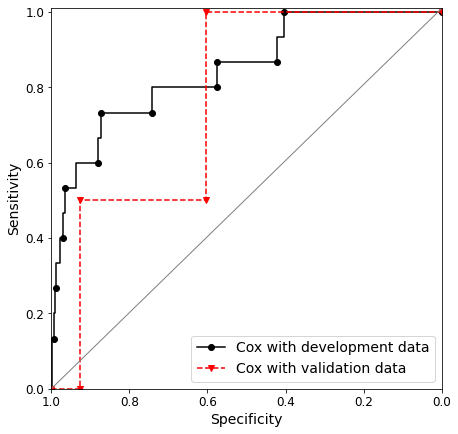

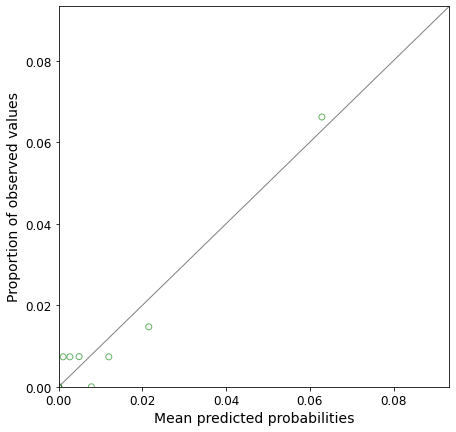

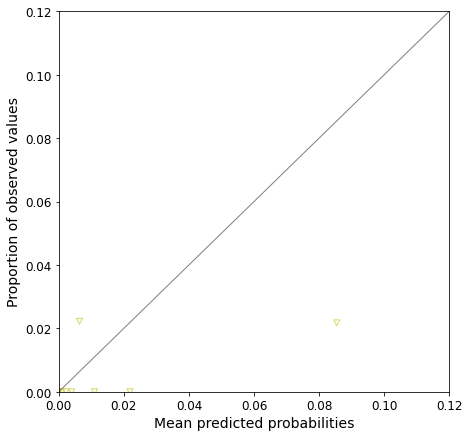

In [43]:
#data prep
data, data_urti_abs_prevl_enc = cox_data_prep(data_urti_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary table
make_summary_table('urti', 'abs_prevl', data_urti_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('urti', 'abs_prevl', data_urti_abs_prevl)

try:
    #build cox model 
    cph_urti_abs_prevl, data_urti_abs_prevl_train, data_urti_abs_prevl_test = cox_model_build('urti', 'abs_prevl', data_urti_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_urti_abs_prevl, '../output/hospitalisation_prediction_urti/', 'betas_cph_urti_abs_prevl.csv', data_urti_abs_prevl_enc, data_urti_abs_prevl, 'sum_betas_cph_urti_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_urti_abs_prevl, 'event_urti_admitted', data_urti_abs_prevl_train, data_urti_abs_prevl_test, '../output/hospitalisation_prediction_urti', 'roc_cph_urti_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_urti_abs_prevl, data_urti_abs_prevl_train, 'event_urti_admitted', data_urti_abs_prevl_test, '../output/hospitalisation_prediction_urti/', 'calibration_cph_urti_abs_prevl_train.jpg', 'calibration_cph_urti_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_urti_abs_prevl, 'urti', 'abs_prevl', data_urti_abs_prevl_train, data_urti_abs_prevl_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident urti

In [44]:
#data prep
data, data_urti_incdt_enc = cox_data_prep(data_urti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary tables from preped data
make_summary_table('urti', 'incdt', data_urti_incdt_enc)
make_summary_table_hosped('urti', 'incdt', data_urti_incdt)

try:
    cph_urti_incdt, data_urti_incdt_train, data_urti_incdt_test = cox_model_abs_build('urti', 'incdt', data_urti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt, 'urti', 'incdt', data_urti_incdt_train, data_urti_incdt_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120161 total observations, 119385 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 120161
number of events observed = 776
   partial log-likelihood = -9059.55
         time fit was run = 2023-06-21 16:59:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.11            -0.24             0.19                 0.79                 1.20
CCI_cat[T.medium]                0.10       1.11       0.12            -0.13             0.33                 0.88                 1.39
CCI_cat[T.high]                  0.06       1.06       0.14            -0.22             0.33                 0.81                 1.39
CCI_cat[T.very_high]            -0.08       0.93       0.13            -0.32             0.17                 0.72                 1.19
age_cat[T.25_34]                -0.00       1.00       0.14            -0.27             0.27                 0.77                 1.31
age_cat[T.35_44]                 0.01       1.01       0.14            -0.25             0.28                 0.78                 1.32
age_cat[T.45_54]                -0.08       0.92       0.14            -0.35             0.19                 0.70                 1.21
age_cat[T.55_64]                 0.14       1.15       0.13            -0.12             0.40                 0.88                 1.49
age_cat[T.65_74]                 0.07       1.07       0.13            -0.20             0.33                 0.82                 1.39
age_cat[T.75_more]               0.01       1.01       0.14            -0.26             0.27                 0.77                 1.31
antibacterial_brit               0.01       1.01       0.03            -0.04             0.06                 0.96                 1.06
bmi_cat[T.obese]                -0.02       0.98       0.13            -0.28             0.25                 0.76                 1.28
bmi_cat[T.overweight]           -0.13       0.88       0.17            -0.46             0.20                 0.63                 1.22
bmi_cat[T.underweight]           0.28       1.32       0.21            -0.14             0.69                 0.87                 2.00
bmi_cat[T.unknown]              -0.10       0.91       0.14            -0.38             0.18                 0.68                 1.20
ethnicity[T.unknown]            -0.13       0.88       0.12            -0.36             0.10                 0.70                 1.10
ethnicity[T.white]              -0.03       0.97       0.10            -0.23             0.17                 0.80                 1.18
flu_vaccine[T.yes]              -0.14       0.87       0.13            -0.39             0.11                 0.68                 1.12
imd[T.medium]                    0.09       1.09       0.12            -0.14             0.32                 0.87                 1.37
imd[T.unaffluent]                0.06       1.06       0.12            -0.17             0.29                 0.84                 1.33
imd[T.unknown]                   0.15       1.16       0.18            -0.20             0.49                 0.82                 1.63
imd[T.very_affluent]             0.10       1.10       0.12            -0.13             0.33                 0.88                 1.39
imd[T.very_unaffluent]          -0.02       0.98       0.12            -0.25             0.22                 0.78                 1.24
region[T.east_midlands]         -0.09       0.92       0.16            -0.41             0.23                 0.66                 1.26
region[T.london]                 0.01       1.01       0.14      

13034


### 5-6- hospital admission related to prevalent urti

In [45]:
#data prep
data, data_urti_prevl_enc = cox_data_prep(data_urti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

#make summary tables from preped data
make_summary_table('urti', 'prevl', data_urti_prevl_enc)
make_summary_table_hosped('urti', 'prevl', data_urti_prevl)

try:
    cph_urti_prevl, data_urti_prevl_train, data_urti_prevl_test = cox_model_abs_build('urti', 'prevl', data_urti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl, 'urti', 'prevl', data_urti_prevl_train, data_urti_prevl_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13194 total observations, 13113 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 13194
number of events observed = 81
   partial log-likelihood = -746.11
         time fit was run = 2023-06-21 16:59:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.07       0.94       0.34            -0.73             0.60                 0.48                 1.83
CCI_cat[T.medium]               -0.01       0.99       0.37            -0.74             0.71                 0.48                 2.04
CCI_cat[T.high]                  0.16       1.17       0.42            -0.67             0.98                 0.51                 2.67
CCI_cat[T.very_high]             0.17       1.18       0.38            -0.58             0.91                 0.56                 2.49
age_cat[T.25_34]                 0.35       1.42       0.43            -0.50             1.20                 0.61                 3.33
age_cat[T.35_44]                 0.35       1.41       0.43            -0.50             1.20                 0.60                 3.31
age_cat[T.45_54]                 0.06       1.06       0.46            -0.84             0.96                 0.43                 2.62
age_cat[T.55_64]                 0.33       1.39       0.43            -0.52             1.18                 0.59                 3.25
age_cat[T.65_74]                 0.12       1.13       0.45            -0.76             1.00                 0.47                 2.73
age_cat[T.75_more]               0.23       1.26       0.44            -0.63             1.10                 0.53                 3.00
antibacterial_brit               0.07       1.07       0.08            -0.08             0.22                 0.92                 1.24
bmi_cat[T.obese]                 0.73       2.07       0.60            -0.45             1.90                 0.64                 6.70
bmi_cat[T.overweight]            1.28       3.58       0.63             0.04             2.52                 1.04                12.39
bmi_cat[T.underweight]           0.99       2.69       0.82            -0.61             2.59                 0.54                13.36
bmi_cat[T.unknown]               0.72       2.05       0.62            -0.50             1.93                 0.61                 6.91
ethnicity[T.unknown]            -0.65       0.52       0.33            -1.31             0.00                 0.27                 1.00
ethnicity[T.white]              -0.54       0.58       0.27            -1.08            -0.01                 0.34                 0.99
flu_vaccine[T.yes]              -0.34       0.71       0.42            -1.18             0.49                 0.31                 1.63
imd[T.medium]                   -0.08       0.93       0.39            -0.85             0.69                 0.43                 2.00
imd[T.unaffluent]                0.43       1.54       0.35            -0.26             1.12                 0.77                 3.08
imd[T.unknown]                   0.37       1.45       0.53            -0.66             1.41                 0.52                 4.08
imd[T.very_affluent]            -0.22       0.80       0.41            -1.02             0.59                 0.36                 1.80
imd[T.very_unaffluent]           0.21       1.24       0.36            -0.50             0.93                 0.61                 2.53
region[T.east_midlands]          0.20       1.23       0.67            -1.11             1.52                 0.33                 4.57
region[T.london]                 0.97       2.63       0.55           

13018


### 5-7- hospital admission related to incident urti with prescribed antibiotics categories

In [46]:
#data prep
data, data_urti_incdt_abs_enc = cox_data_prep(data_urti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_abs, data_urti_incdt_abs_train, data_urti_incdt_abs_test = cox_model_ab_type_build('urti', 'incdt_ab_type', data_urti_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_abs, 'urti', 'incdt_abs', data_urti_incdt_abs_train, data_urti_incdt_abs_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120161 total observations, 119385 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 120161
number of events observed = 776
   partial log-likelihood = -9057.15
         time fit was run = 2023-06-21 16:59:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.11            -0.24             0.19                 0.79                 1.20
CCI_cat[T.medium]                0.10       1.11       0.12            -0.13             0.33                 0.88                 1.39
CCI_cat[T.high]                  0.06       1.06       0.14            -0.21             0.33                 0.81                 1.39
CCI_cat[T.very_high]            -0.07       0.93       0.13            -0.32             0.17                 0.72                 1.19
ab_type_cat[T.Doxycycline]       1.82       6.16       0.87             0.12             3.52                 1.13                33.63
ab_type_cat[T.no]                0.91       2.49       0.71            -0.47             2.30                 0.62                10.00
ab_type_cat[T.other]             0.71       2.04       0.72            -0.70             2.12                 0.50                 8.35
age_cat[T.25_34]                 0.00       1.00       0.14            -0.27             0.27                 0.77                 1.31
age_cat[T.35_44]                 0.01       1.01       0.14            -0.25             0.28                 0.78                 1.32
age_cat[T.45_54]                -0.08       0.92       0.14            -0.35             0.19                 0.70                 1.21
age_cat[T.55_64]                 0.14       1.15       0.13            -0.12             0.40                 0.89                 1.49
age_cat[T.65_74]                 0.07       1.07       0.13            -0.19             0.33                 0.82                 1.39
age_cat[T.75_more]               0.01       1.01       0.14            -0.26             0.27                 0.77                 1.32
antibacterial_brit               0.01       1.01       0.03            -0.04             0.06                 0.96                 1.06
bmi_cat[T.obese]                -0.02       0.98       0.13            -0.28             0.25                 0.76                 1.28
bmi_cat[T.overweight]           -0.13       0.88       0.17            -0.46             0.20                 0.63                 1.22
bmi_cat[T.underweight]           0.28       1.32       0.21            -0.14             0.70                 0.87                 2.01
bmi_cat[T.unknown]              -0.10       0.91       0.14            -0.38             0.19                 0.68                 1.20
ethnicity[T.unknown]            -0.13       0.88       0.12            -0.36             0.10                 0.70                 1.10
ethnicity[T.white]              -0.03       0.97       0.10            -0.23             0.17                 0.80                 1.18
flu_vaccine[T.yes]              -0.14       0.87       0.13            -0.39             0.11                 0.68                 1.12
imd[T.medium]                    0.09       1.09       0.12            -0.14             0.32                 0.87                 1.37
imd[T.unaffluent]                0.06       1.06       0.12            -0.17             0.29                 0.84                 1.33
imd[T.unknown]                   0.15       1.16       0.18            -0.20             0.49                 0.82                 1.63
imd[T.very_affluent]             0.10       1.10       0.12      

13594


### 5-8- hospital admission related to prevalent urti with prescribed antibiotics categories

In [47]:
#data prep
data, data_urti_prevl_abs_enc = cox_data_prep(data_urti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_abs, data_urti_prevl_abs_train, data_urti_prevl_abs_test = cox_model_ab_type_build('urti', 'prevl_ab_type', data_urti_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_abs, 'urti', 'prevl_abs', data_urti_prevl_abs_train, data_urti_prevl_abs_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13194 total observations, 13113 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 13194
number of events observed = 81
   partial log-likelihood = -745.18
         time fit was run = 2023-06-21 16:59:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.34            -0.73             0.61                 0.48                 1.83
CCI_cat[T.medium]                0.00       1.00       0.37            -0.72             0.73                 0.49                 2.07
CCI_cat[T.high]                  0.17       1.19       0.42            -0.65             1.00                 0.52                 2.72
CCI_cat[T.very_high]             0.17       1.19       0.38            -0.57             0.92                 0.56                 2.50
ab_type_cat[T.Doxycycline]     -15.12       0.00    2450.24         -4817.51          4787.26                 0.00                  inf
ab_type_cat[T.no]               -1.51       0.22       0.73            -2.93            -0.09                 0.05                 0.92
ab_type_cat[T.other]            -1.02       0.36       0.77            -2.53             0.49                 0.08                 1.64
age_cat[T.25_34]                 0.35       1.42       0.43            -0.50             1.20                 0.61                 3.33
age_cat[T.35_44]                 0.34       1.41       0.43            -0.51             1.19                 0.60                 3.30
age_cat[T.45_54]                 0.07       1.07       0.46            -0.84             0.97                 0.43                 2.63
age_cat[T.55_64]                 0.33       1.39       0.43            -0.52             1.18                 0.60                 3.26
age_cat[T.65_74]                 0.12       1.12       0.45            -0.76             1.00                 0.47                 2.72
age_cat[T.75_more]               0.25       1.28       0.44            -0.62             1.11                 0.54                 3.04
antibacterial_brit               0.07       1.07       0.08            -0.08             0.22                 0.92                 1.25
bmi_cat[T.obese]                 0.73       2.07       0.60            -0.44             1.90                 0.64                 6.71
bmi_cat[T.overweight]            1.28       3.59       0.63             0.04             2.52                 1.04                12.41
bmi_cat[T.underweight]           0.98       2.67       0.82            -0.62             2.59                 0.54                13.26
bmi_cat[T.unknown]               0.73       2.07       0.62            -0.49             1.94                 0.61                 6.96
ethnicity[T.unknown]            -0.65       0.52       0.33            -1.31             0.01                 0.27                 1.01
ethnicity[T.white]              -0.54       0.58       0.27            -1.08            -0.00                 0.34                 1.00
flu_vaccine[T.yes]              -0.36       0.70       0.43            -1.19             0.47                 0.30                 1.61
imd[T.medium]                   -0.07       0.93       0.39            -0.84             0.70                 0.43                 2.02
imd[T.unaffluent]                0.43       1.53       0.35            -0.26             1.12                 0.77                 3.07
imd[T.unknown]                   0.37       1.45       0.53            -0.66             1.40                 0.52                 4.07
imd[T.very_affluent]            -0.22       0.80       0.41           

13595


### 5-9- stratified by sex
#### 5-9-1- incident males

In [48]:
#data prep
data, data_urti_incdt_males_enc = cox_data_prep(data_urti_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_males, data_urti_incdt_males_train, data_urti_incdt_males_test = cox_model_strat_sex_build('urti', 'incdt_males', data_urti_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_males, 'urti', 'incdt_males', data_urti_incdt_males_train, data_urti_incdt_males_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 58756 total observations, 58397 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 58756
number of events observed = 359
   partial log-likelihood = -3925.62
         time fit was run = 2023-06-21 16:59:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.92       0.16            -0.40             0.23                 0.67                 1.25
CCI_cat[T.medium]                0.14       1.15       0.17            -0.19             0.47                 0.83                 1.60
CCI_cat[T.high]                  0.11       1.12       0.20            -0.27             0.50                 0.76                 1.66
CCI_cat[T.very_high]            -0.12       0.89       0.19            -0.49             0.25                 0.61                 1.29
age_cat[T.25_34]                -0.03       0.97       0.20            -0.42             0.36                 0.66                 1.43
age_cat[T.35_44]                -0.19       0.83       0.20            -0.59             0.22                 0.56                 1.24
age_cat[T.45_54]                -0.11       0.89       0.20            -0.50             0.28                 0.61                 1.32
age_cat[T.55_64]                 0.21       1.23       0.19            -0.16             0.58                 0.86                 1.78
age_cat[T.65_74]                -0.05       0.95       0.20            -0.44             0.34                 0.64                 1.40
age_cat[T.75_more]              -0.08       0.92       0.20            -0.47             0.31                 0.62                 1.36
antibacterial_brit              -0.02       0.98       0.04            -0.09             0.06                 0.91                 1.06
bmi_cat[T.obese]                 0.19       1.20       0.22            -0.24             0.61                 0.79                 1.84
bmi_cat[T.overweight]            0.11       1.12       0.26            -0.40             0.62                 0.67                 1.86
bmi_cat[T.underweight]           0.75       2.11       0.30             0.15             1.34                 1.16                 3.82
bmi_cat[T.unknown]               0.14       1.15       0.23            -0.31             0.59                 0.73                 1.80
ethnicity[T.unknown]            -0.31       0.73       0.18            -0.66             0.04                 0.52                 1.04
ethnicity[T.white]               0.03       1.03       0.15            -0.26             0.32                 0.77                 1.37
flu_vaccine[T.yes]               0.04       1.04       0.17            -0.30             0.38                 0.74                 1.47
imd[T.medium]                    0.10       1.11       0.17            -0.23             0.43                 0.79                 1.54
imd[T.unaffluent]               -0.06       0.94       0.18            -0.41             0.29                 0.66                 1.34
imd[T.unknown]                  -0.03       0.97       0.28            -0.57             0.52                 0.56                 1.68
imd[T.very_affluent]             0.05       1.05       0.17            -0.29             0.39                 0.75                 1.48
imd[T.very_unaffluent]           0.16       1.17       0.17            -0.17             0.49                 0.84                 1.63
region[T.east_midlands]         -0.34       0.71       0.24            -0.82             0.14                 0.44                 1.15
region[T.london]                -0.06       0.94       0.20         

12774


#### 5-9-2- incident females

In [49]:
#data prep
data, data_urti_incdt_females_enc = cox_data_prep(data_urti_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_females, data_urti_incdt_females_train, data_urti_incdt_females_test = cox_model_strat_sex_build('urti', 'incdt_females', data_urti_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_females, 'urti', 'incdt_females', data_urti_incdt_females_train, data_urti_incdt_females_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61404 total observations, 61021 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 61404
number of events observed = 383
   partial log-likelihood = -4206.98
         time fit was run = 2023-06-21 16:59:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.97       0.15            -0.33             0.26                 0.72                 1.30
CCI_cat[T.medium]                0.13       1.13       0.16            -0.19             0.44                 0.83                 1.56
CCI_cat[T.high]                 -0.16       0.85       0.21            -0.57             0.25                 0.57                 1.28
CCI_cat[T.very_high]            -0.31       0.73       0.19            -0.67             0.06                 0.51                 1.06
age_cat[T.25_34]                -0.05       0.95       0.19            -0.42             0.33                 0.66                 1.39
age_cat[T.35_44]                -0.09       0.91       0.19            -0.47             0.29                 0.62                 1.34
age_cat[T.45_54]                -0.15       0.86       0.20            -0.54             0.23                 0.58                 1.26
age_cat[T.55_64]                 0.13       1.13       0.19            -0.24             0.49                 0.79                 1.63
age_cat[T.65_74]                 0.14       1.15       0.18            -0.22             0.50                 0.80                 1.65
age_cat[T.75_more]              -0.10       0.90       0.20            -0.49             0.28                 0.61                 1.32
antibacterial_brit               0.02       1.02       0.04            -0.05             0.09                 0.95                 1.09
bmi_cat[T.obese]                 0.12       1.13       0.20            -0.26             0.51                 0.77                 1.67
bmi_cat[T.overweight]            0.13       1.13       0.24            -0.34             0.59                 0.71                 1.81
bmi_cat[T.underweight]           0.20       1.22       0.33            -0.44             0.83                 0.64                 2.30
bmi_cat[T.unknown]              -0.05       0.95       0.21            -0.47             0.37                 0.63                 1.45
ethnicity[T.unknown]            -0.09       0.92       0.17            -0.41             0.24                 0.66                 1.27
ethnicity[T.white]              -0.05       0.95       0.14            -0.33             0.23                 0.72                 1.26
flu_vaccine[T.yes]              -0.01       0.99       0.17            -0.35             0.32                 0.71                 1.38
imd[T.medium]                    0.07       1.08       0.17            -0.25             0.40                 0.78                 1.50
imd[T.unaffluent]                0.12       1.13       0.16            -0.20             0.44                 0.82                 1.56
imd[T.unknown]                   0.19       1.21       0.24            -0.29             0.67                 0.75                 1.95
imd[T.very_affluent]             0.14       1.14       0.16            -0.19             0.46                 0.83                 1.58
imd[T.very_unaffluent]          -0.13       0.88       0.18            -0.48             0.21                 0.62                 1.23
region[T.east_midlands]         -0.19       0.83       0.24            -0.65             0.27                 0.52                 1.32
region[T.london]                -0.02       0.98       0.19         

12770


#### 5-9-3- prevalent males

In [50]:
#data prep
data, data_urti_prevl_males_enc = cox_data_prep(data_urti_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_males, data_urti_prevl_males_train, data_urti_prevl_males_test = cox_model_strat_sex_build('urti', 'prevl_males', data_urti_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_urti_prevl_males, 'urti', 'prevl_males', data_urti_prevl_males_train, data_urti_prevl_males_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6444 total observations, 6407 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 6444
number of events observed = 37
   partial log-likelihood = -304.02
         time fit was run = 2023-06-21 16:59:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.09       0.53            -0.95             1.12                 0.39                 3.06
CCI_cat[T.medium]               -0.11       0.89       0.61            -1.31             1.08                 0.27                 2.94
CCI_cat[T.high]                 -0.61       0.55       0.84            -2.25             1.04                 0.11                 2.83
CCI_cat[T.very_high]             0.73       2.08       0.54            -0.33             1.79                 0.72                 6.02
age_cat[T.25_34]                -0.38       0.68       0.59            -1.54             0.77                 0.22                 2.16
age_cat[T.35_44]                -0.37       0.69       0.59            -1.52             0.79                 0.22                 2.20
age_cat[T.45_54]                -0.92       0.40       0.69            -2.27             0.44                 0.10                 1.55
age_cat[T.55_64]                -0.12       0.89       0.54            -1.18             0.94                 0.31                 2.55
age_cat[T.65_74]                -0.58       0.56       0.63            -1.81             0.65                 0.16                 1.92
age_cat[T.75_more]              -0.25       0.78       0.56            -1.34             0.85                 0.26                 2.34
antibacterial_brit               0.06       1.06       0.11            -0.17             0.28                 0.84                 1.32
bmi_cat[T.obese]                16.83   2.05e+07    2676.70         -5229.41          5263.08                 0.00                  inf
bmi_cat[T.overweight]           17.88   5.81e+07    2676.70         -5228.36          5264.12                 0.00                  inf
bmi_cat[T.underweight]          17.54   4.13e+07    2676.70         -5228.71          5263.78                 0.00                  inf
bmi_cat[T.unknown]              16.95   2.29e+07    2676.70         -5229.29          5263.19                 0.00                  inf
ethnicity[T.unknown]            -0.06       0.95       0.65            -1.33             1.21                 0.27                 3.37
ethnicity[T.white]               0.52       1.68       0.54            -0.54             1.57                 0.58                 4.81
flu_vaccine[T.yes]              -0.32       0.72       0.60            -1.51             0.86                 0.22                 2.37
imd[T.medium]                    0.15       1.16       0.48            -0.79             1.08                 0.46                 2.96
imd[T.unaffluent]               -0.35       0.70       0.54            -1.42             0.71                 0.24                 2.04
imd[T.unknown]                  -0.07       0.93       0.80            -1.63             1.49                 0.20                 4.46
imd[T.very_affluent]            -0.18       0.84       0.52            -1.20             0.85                 0.30                 2.33
imd[T.very_unaffluent]          -0.87       0.42       0.62            -2.08             0.34                 0.12                 1.40
region[T.east_midlands]          0.23       1.26       0.77            -1.27             1.73                 0.28                 5.66
region[T.london]                 0.17       1.18       0.69            -1

12821


#### 5-9-4- prevalent females

In [51]:
try:
    #data prep
    data, data_urti_prevl_females_enc = cox_data_prep(data_urti_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

    #cox model
    cph_urti_prevl_females, data_urti_prevl_females_train, data_urti_prevl_females_test = cox_model_strat_sex_build('urti', 'prevl_females', data_urti_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_females, 'urti', 'prevl_females', data_urti_prevl_females_train, data_urti_prevl_females_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6750 total observations, 6700 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 6750
number of events observed = 50
   partial log-likelihood = -423.22
         time fit was run = 2023-06-21 16:59:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       0.48            -0.64             1.23                 0.53                 3.41
CCI_cat[T.medium]                0.61       1.84       0.49            -0.35             1.57                 0.71                 4.80
CCI_cat[T.high]                  0.53       1.70       0.56            -0.56             1.62                 0.57                 5.07
CCI_cat[T.very_high]             0.05       1.05       0.58            -1.09             1.18                 0.34                 3.26
age_cat[T.25_34]                 0.33       1.39       0.53            -0.71             1.37                 0.49                 3.93
age_cat[T.35_44]                 0.20       1.22       0.54            -0.86             1.26                 0.42                 3.52
age_cat[T.45_54]                 0.09       1.09       0.56            -1.00             1.18                 0.37                 3.27
age_cat[T.55_64]                -0.08       0.92       0.58            -1.22             1.05                 0.30                 2.86
age_cat[T.65_74]                -0.50       0.60       0.65            -1.77             0.77                 0.17                 2.15
age_cat[T.75_more]               0.47       1.60       0.52            -0.54             1.49                 0.58                 4.42
antibacterial_brit               0.05       1.05       0.10            -0.14             0.24                 0.87                 1.27
bmi_cat[T.obese]                 0.66       1.94       0.73            -0.78             2.10                 0.46                 8.17
bmi_cat[T.overweight]            0.51       1.67       0.84            -1.13             2.16                 0.32                 8.65
bmi_cat[T.underweight]           1.35       3.87       0.92            -0.44             3.15                 0.64                23.27
bmi_cat[T.unknown]               0.65       1.91       0.76            -0.85             2.14                 0.43                 8.48
ethnicity[T.unknown]            -0.37       0.69       0.43            -1.21             0.48                 0.30                 1.61
ethnicity[T.white]              -0.38       0.68       0.37            -1.11             0.34                 0.33                 1.41
flu_vaccine[T.yes]              -0.53       0.59       0.60            -1.70             0.64                 0.18                 1.89
imd[T.medium]                   -0.37       0.69       0.47            -1.28             0.55                 0.28                 1.73
imd[T.unaffluent]                0.25       1.29       0.40            -0.54             1.05                 0.58                 2.84
imd[T.unknown]                  -0.37       0.69       0.77            -1.88             1.14                 0.15                 3.13
imd[T.very_affluent]            -0.56       0.57       0.49            -1.51             0.40                 0.22                 1.49
imd[T.very_unaffluent]          -0.40       0.67       0.47            -1.31             0.52                 0.27                 1.68
region[T.east_midlands]          0.28       1.32       0.76            -1.22             1.78                 0.30                 5.92
region[T.london]                 1.03       2.81       0.63            -0

12793


### 5-10- stratified by age category
#### 5-10-1- incident

In [52]:
#data prep
data, data_urti_incdt_15_24_enc = cox_data_prep(data_urti_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_15_24, data_urti_incdt_15_24_train, data_urti_incdt_15_24_test = cox_model_strat_age_build('urti', 'incdt_15_24', data_urti_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_15_24, 'urti', 'incdt_15_24', data_urti_incdt_15_24_train, data_urti_incdt_15_24_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16996 total observations, 16882 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 16996
number of events observed = 114
   partial log-likelihood = -1089.91
         time fit was run = 2023-06-21 16:59:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.24       1.27       0.29            -0.34             0.81                 0.71                 2.26
CCI_cat[T.medium]                0.21       1.23       0.32            -0.42             0.84                 0.66                 2.31
CCI_cat[T.high]                  0.06       1.06       0.39            -0.71             0.83                 0.49                 2.28
CCI_cat[T.very_high]             0.15       1.16       0.34            -0.52             0.81                 0.60                 2.25
antibacterial_brit               0.03       1.03       0.06            -0.09             0.16                 0.91                 1.17
bmi_cat[T.obese]                -0.15       0.86       0.33            -0.79             0.50                 0.45                 1.64
bmi_cat[T.overweight]           -0.05       0.95       0.40            -0.84             0.74                 0.43                 2.10
bmi_cat[T.underweight]           0.43       1.53       0.51            -0.57             1.42                 0.56                 4.15
bmi_cat[T.unknown]              -0.52       0.59       0.37            -1.25             0.21                 0.29                 1.23
ethnicity[T.unknown]            -0.82       0.44       0.34            -1.49            -0.15                 0.23                 0.86
ethnicity[T.white]              -0.03       0.97       0.25            -0.52             0.47                 0.60                 1.59
flu_vaccine[T.yes]              -0.05       0.95       0.33            -0.71             0.60                 0.49                 1.81
imd[T.medium]                   -0.15       0.86       0.28            -0.71             0.40                 0.49                 1.50
imd[T.unaffluent]               -0.22       0.80       0.29            -0.79             0.35                 0.45                 1.42
imd[T.unknown]                  -0.75       0.47       0.61            -1.94             0.44                 0.14                 1.56
imd[T.very_affluent]            -0.05       0.95       0.28            -0.60             0.50                 0.55                 1.65
imd[T.very_unaffluent]          -0.51       0.60       0.32            -1.13             0.11                 0.32                 1.12
region[T.east_midlands]         -0.98       0.37       0.48            -1.92            -0.04                 0.15                 0.96
region[T.london]                -0.73       0.48       0.35            -1.43            -0.04                 0.24                 0.96
region[T.north_east]            -0.17       0.84       0.37            -0.89             0.55                 0.41                 1.73
region[T.north_west]             0.04       1.05       0.35            -0.63             0.72                 0.53                 2.06
region[T.south_east]            -0.29       0.75       0.38            -1.04             0.46                 0.36                 1.59
region[T.south_west]            -0.30       0.74       0.37            -1.04             0.43                 0.35                 1.54
region[T.west_midlands]         -0.42       0.66       0.39            -1.19             0.35                 0.30                 1.42
region[T.yorkshire]             -0.70       0.50       0.43         

11416


In [53]:
#data prep
data, data_urti_incdt_25_34_enc = cox_data_prep(data_urti_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_25_34, data_urti_incdt_25_34_train, data_urti_incdt_25_34_test = cox_model_strat_age_build('urti', 'incdt_25_34', data_urti_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_25_34, 'urti', 'incdt_25_34', data_urti_incdt_25_34_train, data_urti_incdt_25_34_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17241 total observations, 17136 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17241
number of events observed = 105
   partial log-likelihood = -1009.29
         time fit was run = 2023-06-21 16:59:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.41       0.67       0.29            -0.98             0.16                 0.38                 1.18
CCI_cat[T.medium]                0.08       1.08       0.29            -0.50             0.65                 0.61                 1.92
CCI_cat[T.high]                 -0.50       0.61       0.42            -1.32             0.32                 0.27                 1.38
CCI_cat[T.very_high]            -0.04       0.96       0.32            -0.66             0.58                 0.52                 1.78
antibacterial_brit              -0.01       0.99       0.07            -0.15             0.12                 0.86                 1.13
bmi_cat[T.obese]                 0.13       1.14       0.38            -0.61             0.87                 0.54                 2.39
bmi_cat[T.overweight]            0.08       1.09       0.46            -0.81             0.98                 0.44                 2.66
bmi_cat[T.underweight]          -0.28       0.75       0.79            -1.83             1.27                 0.16                 3.55
bmi_cat[T.unknown]               0.05       1.06       0.41            -0.74             0.85                 0.48                 2.33
ethnicity[T.unknown]            -0.02       0.98       0.35            -0.71             0.67                 0.49                 1.96
ethnicity[T.white]               0.32       1.37       0.30            -0.28             0.91                 0.76                 2.48
flu_vaccine[T.yes]               0.03       1.03       0.32            -0.60             0.66                 0.55                 1.93
imd[T.medium]                   -0.25       0.78       0.37            -0.98             0.47                 0.38                 1.60
imd[T.unaffluent]                0.53       1.70       0.31            -0.07             1.14                 0.93                 3.12
imd[T.unknown]                   0.74       2.09       0.41            -0.07             1.54                 0.93                 4.68
imd[T.very_affluent]            -0.08       0.92       0.35            -0.78             0.61                 0.46                 1.84
imd[T.very_unaffluent]           0.37       1.45       0.32            -0.26             1.00                 0.77                 2.71
region[T.east_midlands]          0.31       1.36       0.44            -0.55             1.18                 0.57                 3.24
region[T.london]                 0.19       1.20       0.40            -0.60             0.97                 0.55                 2.65
region[T.north_east]             0.06       1.06       0.47            -0.87             0.98                 0.42                 2.67
region[T.north_west]            -0.05       0.95       0.49            -1.01             0.90                 0.36                 2.46
region[T.south_east]             0.33       1.39       0.44            -0.53             1.20                 0.59                 3.31
region[T.south_west]             0.10       1.11       0.46            -0.80             1.00                 0.45                 2.73
region[T.west_midlands]          0.70       2.02       0.41            -0.11             1.51                 0.90                 4.54
region[T.yorkshire]             -0.07       0.94       0.49         

11388


In [54]:
#data prep
data, data_urti_incdt_35_44_enc = cox_data_prep(data_urti_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_35_44, data_urti_incdt_35_44_train, data_urti_incdt_35_44_test = cox_model_strat_age_build('urti', 'incdt_35_44', data_urti_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_35_44, 'urti', 'incdt_35_44', data_urti_incdt_35_44_train, data_urti_incdt_35_44_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17380 total observations, 17279 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17380
number of events observed = 101
   partial log-likelihood = -963.63
         time fit was run = 2023-06-21 16:59:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.34       0.71       0.29            -0.90             0.22                 0.41                 1.24
CCI_cat[T.medium]               -0.08       0.92       0.31            -0.68             0.52                 0.50                 1.68
CCI_cat[T.high]                 -0.66       0.52       0.44            -1.52             0.20                 0.22                 1.23
CCI_cat[T.very_high]            -0.14       0.87       0.32            -0.77             0.49                 0.46                 1.64
antibacterial_brit              -0.05       0.96       0.07            -0.18             0.09                 0.83                 1.10
bmi_cat[T.obese]                 0.51       1.66       0.47            -0.41             1.42                 0.67                 4.15
bmi_cat[T.overweight]            0.43       1.54       0.53            -0.62             1.47                 0.54                 4.37
bmi_cat[T.underweight]           0.83       2.28       0.63            -0.42             2.07                 0.66                 7.90
bmi_cat[T.unknown]               0.16       1.18       0.50            -0.82             1.14                 0.44                 3.12
ethnicity[T.unknown]             0.44       1.56       0.39            -0.33             1.22                 0.72                 3.38
ethnicity[T.white]               0.66       1.94       0.35            -0.04             1.36                 0.97                 3.88
flu_vaccine[T.yes]               0.28       1.33       0.29            -0.28             0.85                 0.75                 2.33
imd[T.medium]                   -0.28       0.76       0.35            -0.96             0.40                 0.38                 1.49
imd[T.unaffluent]                0.02       1.03       0.31            -0.58             0.63                 0.56                 1.88
imd[T.unknown]                   0.35       1.41       0.42            -0.47             1.16                 0.63                 3.20
imd[T.very_affluent]            -0.19       0.83       0.33            -0.83             0.45                 0.44                 1.57
imd[T.very_unaffluent]          -0.02       0.98       0.31            -0.64             0.59                 0.53                 1.80
region[T.east_midlands]         -0.74       0.48       0.49            -1.71             0.23                 0.18                 1.26
region[T.london]                -0.26       0.77       0.35            -0.96             0.43                 0.38                 1.54
region[T.north_east]             0.02       1.02       0.39            -0.76             0.79                 0.47                 2.20
region[T.north_west]            -0.62       0.54       0.47            -1.54             0.30                 0.21                 1.35
region[T.south_east]            -0.61       0.55       0.47            -1.53             0.31                 0.22                 1.37
region[T.south_west]            -0.56       0.57       0.45            -1.44             0.32                 0.24                 1.38
region[T.west_midlands]          0.25       1.29       0.36            -0.46             0.97                 0.63                 2.64
region[T.yorkshire]             -0.50       0.61       0.45          

11418


In [55]:
#data prep
data, data_urti_incdt_45_54_enc = cox_data_prep(data_urti_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_45_54, data_urti_incdt_45_54_train, data_urti_incdt_45_54_test = cox_model_strat_age_build('urti', 'incdt_45_54', data_urti_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_45_54, 'urti', 'incdt_45_54', data_urti_incdt_45_54_train, data_urti_incdt_45_54_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17444 total observations, 17343 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17444
number of events observed = 101
   partial log-likelihood = -966.28
         time fit was run = 2023-06-21 16:59:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.37       0.69       0.28            -0.92             0.18                 0.40                 1.19
CCI_cat[T.medium]               -0.65       0.52       0.34            -1.32             0.03                 0.27                 1.03
CCI_cat[T.high]                  0.05       1.05       0.34            -0.62             0.72                 0.54                 2.06
CCI_cat[T.very_high]            -0.15       0.86       0.31            -0.76             0.46                 0.47                 1.58
antibacterial_brit               0.01       1.01       0.07            -0.12             0.15                 0.88                 1.16
bmi_cat[T.obese]                 0.14       1.15       0.40            -0.65             0.93                 0.52                 2.54
bmi_cat[T.overweight]           -0.26       0.77       0.54            -1.31             0.79                 0.27                 2.19
bmi_cat[T.underweight]           0.99       2.69       0.54            -0.06             2.04                 0.94                 7.71
bmi_cat[T.unknown]               0.29       1.34       0.42            -0.54             1.12                 0.58                 3.05
ethnicity[T.unknown]             0.49       1.64       0.37            -0.23             1.22                 0.79                 3.37
ethnicity[T.white]               0.46       1.58       0.34            -0.21             1.12                 0.81                 3.08
flu_vaccine[T.yes]               0.49       1.63       0.28            -0.06             1.04                 0.94                 2.83
imd[T.medium]                    0.28       1.33       0.29            -0.29             0.85                 0.75                 2.34
imd[T.unaffluent]               -0.72       0.49       0.38            -1.47             0.03                 0.23                 1.03
imd[T.unknown]                  -0.34       0.71       0.55            -1.41             0.73                 0.24                 2.08
imd[T.very_affluent]            -0.01       0.99       0.31            -0.62             0.59                 0.54                 1.81
imd[T.very_unaffluent]          -0.21       0.81       0.33            -0.85             0.43                 0.43                 1.53
region[T.east_midlands]         -0.52       0.59       0.48            -1.46             0.41                 0.23                 1.51
region[T.london]                -0.38       0.68       0.38            -1.12             0.36                 0.33                 1.43
region[T.north_east]             0.15       1.16       0.39            -0.61             0.91                 0.54                 2.49
region[T.north_west]            -0.07       0.94       0.42            -0.89             0.76                 0.41                 2.13
region[T.south_east]            -0.45       0.64       0.46            -1.35             0.44                 0.26                 1.56
region[T.south_west]            -0.15       0.86       0.43            -0.99             0.69                 0.37                 1.99
region[T.west_midlands]          0.09       1.09       0.40            -0.70             0.87                 0.50                 2.40
region[T.yorkshire]             -0.37       0.69       0.46          

11399


In [56]:
#data prep
data, data_urti_incdt_55_64_enc = cox_data_prep(data_urti_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_55_64, data_urti_incdt_55_64_train, data_urti_incdt_55_64_test = cox_model_strat_age_build('urti', 'incdt_55_64', data_urti_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_55_64, 'urti', 'incdt_55_64', data_urti_incdt_55_64_train, data_urti_incdt_55_64_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16860 total observations, 16742 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 16860
number of events observed = 118
   partial log-likelihood = -1134.43
         time fit was run = 2023-06-21 16:59:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.03       0.29            -0.55             0.60                 0.58                 1.82
CCI_cat[T.medium]                0.54       1.72       0.29            -0.04             1.12                 0.97                 3.05
CCI_cat[T.high]                  0.28       1.32       0.36            -0.43             0.99                 0.65                 2.69
CCI_cat[T.very_high]            -0.43       0.65       0.38            -1.17             0.31                 0.31                 1.36
antibacterial_brit               0.04       1.04       0.06            -0.09             0.16                 0.92                 1.18
bmi_cat[T.obese]                 0.13       1.13       0.36            -0.57             0.82                 0.56                 2.28
bmi_cat[T.overweight]            0.15       1.16       0.42            -0.68             0.98                 0.51                 2.66
bmi_cat[T.underweight]           0.43       1.54       0.56            -0.67             1.53                 0.51                 4.60
bmi_cat[T.unknown]              -0.15       0.86       0.39            -0.92             0.61                 0.40                 1.84
ethnicity[T.unknown]             0.19       1.21       0.31            -0.42             0.80                 0.66                 2.22
ethnicity[T.white]               0.18       1.19       0.28            -0.37             0.72                 0.69                 2.05
flu_vaccine[T.yes]               0.12       1.13       0.29            -0.45             0.70                 0.64                 2.01
imd[T.medium]                    0.19       1.21       0.32            -0.42             0.81                 0.65                 2.25
imd[T.unaffluent]                0.25       1.28       0.31            -0.36             0.86                 0.70                 2.37
imd[T.unknown]                  -0.22       0.80       0.55            -1.30             0.86                 0.27                 2.37
imd[T.very_affluent]             0.14       1.15       0.32            -0.49             0.77                 0.61                 2.16
imd[T.very_unaffluent]           0.43       1.54       0.30            -0.16             1.03                 0.85                 2.79
region[T.east_midlands]          0.04       1.04       0.42            -0.78             0.86                 0.46                 2.35
region[T.london]                 0.16       1.17       0.36            -0.55             0.86                 0.58                 2.37
region[T.north_east]             0.38       1.46       0.39            -0.39             1.15                 0.68                 3.15
region[T.north_west]            -0.09       0.92       0.44            -0.95             0.77                 0.39                 2.16
region[T.south_east]            -0.04       0.96       0.44            -0.89             0.82                 0.41                 2.27
region[T.south_west]             0.02       1.02       0.42            -0.80             0.83                 0.45                 2.30
region[T.west_midlands]         -0.14       0.87       0.44            -1.00             0.71                 0.37                 2.04
region[T.yorkshire]             -0.05       0.95       0.43         

11386


In [57]:
#data prep
data, data_urti_incdt_65_74_enc = cox_data_prep(data_urti_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_65_74, data_urti_incdt_65_74_train, data_urti_incdt_65_74_test = cox_model_strat_age_build('urti', 'incdt_65_74', data_urti_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_65_74, 'urti', 'incdt_65_74', data_urti_incdt_65_74_train, data_urti_incdt_65_74_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17055 total observations, 16940 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17055
number of events observed = 115
   partial log-likelihood = -1100.25
         time fit was run = 2023-06-21 17:00:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.40       1.49       0.31            -0.20             1.00                 0.82                 2.72
CCI_cat[T.medium]                0.74       2.10       0.31             0.13             1.36                 1.14                 3.88
CCI_cat[T.high]                 -0.26       0.77       0.46            -1.17             0.65                 0.31                 1.92
CCI_cat[T.very_high]            -0.27       0.77       0.40            -1.06             0.53                 0.35                 1.69
antibacterial_brit              -0.12       0.89       0.07            -0.26             0.02                 0.77                 1.02
bmi_cat[T.obese]                -0.19       0.82       0.33            -0.84             0.45                 0.43                 1.58
bmi_cat[T.overweight]           -0.35       0.70       0.44            -1.21             0.51                 0.30                 1.66
bmi_cat[T.underweight]          -0.39       0.68       0.65            -1.66             0.89                 0.19                 2.44
bmi_cat[T.unknown]               0.04       1.05       0.35            -0.63             0.72                 0.53                 2.06
ethnicity[T.unknown]            -0.10       0.91       0.30            -0.68             0.48                 0.51                 1.62
ethnicity[T.white]              -0.18       0.83       0.26            -0.69             0.33                 0.50                 1.39
flu_vaccine[T.yes]              -0.71       0.49       0.42            -1.53             0.12                 0.22                 1.12
imd[T.medium]                    0.01       1.01       0.31            -0.60             0.61                 0.55                 1.84
imd[T.unaffluent]                0.13       1.14       0.30            -0.45             0.72                 0.63                 2.05
imd[T.unknown]                   0.42       1.52       0.42            -0.40             1.23                 0.67                 3.44
imd[T.very_affluent]             0.08       1.09       0.31            -0.52             0.68                 0.60                 1.98
imd[T.very_unaffluent]          -0.10       0.91       0.32            -0.72             0.52                 0.49                 1.69
region[T.east_midlands]         -0.20       0.82       0.42            -1.03             0.62                 0.36                 1.87
region[T.london]                 0.02       1.02       0.34            -0.65             0.69                 0.52                 2.00
region[T.north_east]            -0.11       0.90       0.41            -0.91             0.70                 0.40                 2.01
region[T.north_west]            -0.27       0.76       0.43            -1.13             0.58                 0.32                 1.78
region[T.south_east]             0.39       1.48       0.37            -0.33             1.12                 0.72                 3.05
region[T.south_west]             0.09       1.09       0.39            -0.68             0.86                 0.51                 2.36
region[T.west_midlands]         -0.16       0.85       0.42            -0.98             0.67                 0.37                 1.95
region[T.yorkshire]             -0.57       0.56       0.47         

11412


In [58]:
#data prep
data, data_urti_incdt_75_more_enc = cox_data_prep(data_urti_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_75_more, data_urti_incdt_75_more_train, data_urti_incdt_75_more_test = cox_model_strat_age_build('urti', 'incdt_75_more', data_urti_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_75_more, 'urti', 'incdt_75_more', data_urti_incdt_75_more_train, data_urti_incdt_75_more_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17182 total observations, 17084 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 17182
number of events observed = 98
   partial log-likelihood = -944.78
         time fit was run = 2023-06-21 17:00:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.26       1.30       0.31            -0.35             0.87                 0.70                 2.39
CCI_cat[T.medium]                0.27       1.32       0.34            -0.40             0.95                 0.67                 2.57
CCI_cat[T.high]                  0.20       1.23       0.40            -0.59             0.99                 0.56                 2.70
CCI_cat[T.very_high]            -0.02       0.98       0.39            -0.78             0.73                 0.46                 2.08
antibacterial_brit               0.07       1.08       0.07            -0.06             0.21                 0.94                 1.23
bmi_cat[T.obese]                -0.32       0.73       0.33            -0.97             0.33                 0.38                 1.40
bmi_cat[T.overweight]           -0.36       0.70       0.43            -1.20             0.47                 0.30                 1.61
bmi_cat[T.underweight]          -0.42       0.66       0.65            -1.70             0.86                 0.18                 2.37
bmi_cat[T.unknown]              -0.50       0.61       0.37            -1.23             0.24                 0.29                 1.27
ethnicity[T.unknown]             0.01       1.01       0.34            -0.65             0.67                 0.52                 1.95
ethnicity[T.white]               0.06       1.06       0.30            -0.53             0.64                 0.59                 1.89
flu_vaccine[T.yes]              -0.37       0.69       0.39            -1.14             0.40                 0.32                 1.49
imd[T.medium]                    0.11       1.11       0.33            -0.55             0.76                 0.58                 2.14
imd[T.unaffluent]               -0.05       0.95       0.35            -0.75             0.64                 0.47                 1.90
imd[T.unknown]                   0.15       1.16       0.51            -0.85             1.15                 0.43                 3.15
imd[T.very_affluent]             0.27       1.31       0.33            -0.37             0.91                 0.69                 2.48
imd[T.very_unaffluent]           0.24       1.27       0.33            -0.40             0.88                 0.67                 2.42
region[T.east_midlands]          0.28       1.32       0.44            -0.59             1.14                 0.56                 3.14
region[T.london]                 0.17       1.19       0.40            -0.61             0.95                 0.54                 2.59
region[T.north_east]            -0.06       0.94       0.49            -1.01             0.89                 0.36                 2.44
region[T.north_west]             0.02       1.02       0.47            -0.90             0.95                 0.41                 2.58
region[T.south_east]             0.50       1.64       0.42            -0.33             1.32                 0.72                 3.76
region[T.south_west]             0.23       1.26       0.44            -0.63             1.10                 0.53                 3.00
region[T.west_midlands]         -0.12       0.89       0.49            -1.07             0.84                 0.34                 2.31
region[T.yorkshire]             -0.85       0.43       0.60           

11392


#### 5-10-2- prevalent

In [59]:
#data prep
data, data_urti_prevl_15_24_enc = cox_data_prep(data_urti_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_15_24, data_urti_prevl_15_24_train, data_urti_prevl_15_24_test = cox_model_strat_age_build('urti', 'prevl_15_24', data_urti_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_15_24, 'urti', 'prevl_15_24', data_urti_prevl_15_24_train, data_urti_prevl_15_24_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1828 total observations, 1813 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1828
number of events observed = 15
   partial log-likelihood = -105.84
         time fit was run = 2023-06-21 17:00:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.04       2.83       1.08            -1.07             3.15                 0.34                23.42
CCI_cat[T.medium]                1.09       2.97       1.13            -1.12             3.30                 0.33                27.01
CCI_cat[T.high]                  1.02       2.76       1.23            -1.40             3.43                 0.25                30.93
CCI_cat[T.very_high]            -0.14       0.87       1.42            -2.92             2.65                 0.05                14.10
antibacterial_brit               0.01       1.01       0.18            -0.35             0.37                 0.71                 1.44
bmi_cat[T.obese]                -0.06       0.94       1.09            -2.19             2.07                 0.11                 7.90
bmi_cat[T.overweight]            0.98       2.66       1.14            -1.26             3.22                 0.28                25.10
bmi_cat[T.underweight]         -14.73       0.00    2724.47         -5354.59          5325.13                 0.00                  inf
bmi_cat[T.unknown]              -0.14       0.87       1.18            -2.45             2.16                 0.09                 8.71
ethnicity[T.unknown]            -0.48       0.62       0.94            -2.32             1.36                 0.10                 3.88
ethnicity[T.white]              -0.11       0.89       0.80            -1.68             1.45                 0.19                 4.26
flu_vaccine[T.yes]              -0.62       0.54       1.06            -2.69             1.45                 0.07                 4.28
imd[T.medium]                    0.59       1.81       0.88            -1.13             2.32                 0.32                10.18
imd[T.unaffluent]                0.50       1.65       0.93            -1.31             2.32                 0.27                10.14
imd[T.unknown]                   0.81       2.24       1.25            -1.64             3.26                 0.19                25.98
imd[T.very_affluent]             0.13       1.14       1.00            -1.84             2.10                 0.16                 8.15
imd[T.very_unaffluent]           0.45       1.57       0.92            -1.36             2.26                 0.26                 9.58
region[T.east_midlands]          0.63       1.88       1.23            -1.77             3.04                 0.17                20.94
region[T.london]                -0.02       0.98       1.23            -2.44             2.39                 0.09                10.89
region[T.north_east]            -0.11       0.90       1.42            -2.89             2.67                 0.06                14.48
region[T.north_west]             0.03       1.03       1.42            -2.76             2.81                 0.06                16.68
region[T.south_east]             0.64       1.89       1.24            -1.79             3.06                 0.17                21.42
region[T.south_west]             1.02       2.78       1.16            -1.25             3.29                 0.29                26.95
region[T.west_midlands]         -0.02       0.98       1.43            -2.82             2.77                 0.06                16.03
region[T.yorkshire]              0.81       2.25       1.23            -1

11418


In [60]:
#data prep
data, data_urti_prevl_25_34_enc = cox_data_prep(data_urti_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_25_34, data_urti_prevl_25_34_train, data_urti_prevl_25_34_test = cox_model_strat_age_build('urti', 'prevl_25_34', data_urti_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_25_34, 'urti', 'prevl_25_34', data_urti_prevl_25_34_train, data_urti_prevl_25_34_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1869 total observations, 1859 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1869
number of events observed = 10
   partial log-likelihood = -59.26
         time fit was run = 2023-06-21 17:00:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.19       1.21       1.24            -2.24             2.62                 0.11                13.75
CCI_cat[T.medium]                0.35       1.42       1.25            -2.10             2.79                 0.12                16.36
CCI_cat[T.high]                  1.09       2.99       1.25            -1.36             3.55                 0.26                34.87
CCI_cat[T.very_high]             1.18       3.24       1.19            -1.15             3.51                 0.32                33.31
antibacterial_brit              -0.72       0.49       0.40            -1.50             0.07                 0.22                 1.07
bmi_cat[T.obese]                18.00   6.55e+07    6827.53        -13363.72         13399.71                 0.00                  inf
bmi_cat[T.overweight]           17.39   3.55e+07    6827.53        -13364.33         13399.10                 0.00                  inf
bmi_cat[T.underweight]          -0.40       0.67   13577.17        -26611.16         26610.36                 0.00                  inf
bmi_cat[T.unknown]              17.33   3.34e+07    6827.53        -13364.39         13399.04                 0.00                  inf
ethnicity[T.unknown]             0.43       1.54       1.27            -2.05             2.91                 0.13                18.43
ethnicity[T.white]               0.94       2.57       1.12            -1.25             3.13                 0.29                22.92
flu_vaccine[T.yes]             -17.65       0.00    6133.72        -12039.53         12004.22                 0.00                  inf
imd[T.medium]                   18.36   9.42e+07    5547.84        -10855.20         10891.92                 0.00                  inf
imd[T.unaffluent]               17.94   6.15e+07    5547.84        -10855.63         10891.50                 0.00                  inf
imd[T.unknown]                  -0.17       0.85   11506.09        -22551.69         22551.35                 0.00                  inf
imd[T.very_affluent]            18.45   1.03e+08    5547.84        -10855.11         10892.02                 0.00                  inf
imd[T.very_unaffluent]          -0.18       0.83    7761.81        -15213.04         15212.68                 0.00                  inf
region[T.east_midlands]          0.21       1.23       1.46            -2.65             3.06                 0.07                21.41
region[T.london]                 0.08       1.08       1.25            -2.38             2.54                 0.09                12.62
region[T.north_east]             0.29       1.33       1.26            -2.18             2.76                 0.11                15.81
region[T.north_west]            -0.30       0.74       1.46            -3.15             2.56                 0.04                12.88
region[T.south_east]            -0.20       0.82       1.46            -3.05             2.66                 0.05                14.24
region[T.south_west]           -17.47       0.00    6221.58        -12211.54         12176.60                 0.00                  inf
region[T.west_midlands]         -0.09       0.91       1.44            -2.92             2.74                 0.05                15.43
region[T.yorkshire]             -0.22       0.80       1.46            -3.

11591


In [61]:
#data prep
data, data_urti_prevl_35_44_enc = cox_data_prep(data_urti_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_35_44, data_urti_prevl_35_44_train, data_urti_prevl_35_44_test = cox_model_strat_age_build('urti', 'prevl_35_44', data_urti_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_35_44, 'urti', 'prevl_35_44', data_urti_prevl_35_44_train, data_urti_prevl_35_44_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1898 total observations, 1885 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1898
number of events observed = 13
   partial log-likelihood = -71.13
         time fit was run = 2023-06-21 17:00:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  17.52   4.06e+07    5008.75         -9799.44          9834.48                 0.00                  inf
CCI_cat[T.medium]               18.45   1.03e+08    5008.75         -9798.51          9835.42                 0.00                  inf
CCI_cat[T.high]                 17.78   5.29e+07    5008.75         -9799.18          9834.75                 0.00                  inf
CCI_cat[T.very_high]            17.82   5.47e+07    5008.75         -9799.15          9834.78                 0.00                  inf
antibacterial_brit               0.39       1.47       0.21            -0.02             0.80                 0.98                 2.22
bmi_cat[T.obese]                -0.70       0.50       1.20            -3.05             1.64                 0.05                 5.17
bmi_cat[T.overweight]            0.47       1.59       1.30            -2.08             3.01                 0.12                20.37
bmi_cat[T.underweight]           2.07       7.95       1.29            -0.45             4.60                 0.64                99.58
bmi_cat[T.unknown]              -0.23       0.79       1.22            -2.63             2.17                 0.07                 8.73
ethnicity[T.unknown]            -1.73       0.18       0.93            -3.56             0.10                 0.03                 1.10
ethnicity[T.white]              -1.21       0.30       0.65            -2.49             0.08                 0.08                 1.08
flu_vaccine[T.yes]               0.48       1.61       0.86            -1.21             2.16                 0.30                 8.70
imd[T.medium]                   -1.32       0.27       1.27            -3.82             1.17                 0.02                 3.23
imd[T.unaffluent]               -1.00       0.37       1.27            -3.49             1.49                 0.03                 4.45
imd[T.unknown]                 -18.44       0.00   10753.12        -21094.18         21057.29                 0.00                  inf
imd[T.very_affluent]            -0.61       0.55       1.08            -2.73             1.52                 0.07                 4.56
imd[T.very_unaffluent]           0.67       1.96       0.88            -1.05             2.39                 0.35                10.95
region[T.east_midlands]         -0.90       0.41    7728.06        -15147.61         15145.82                 0.00                  inf
region[T.london]                17.52   4.05e+07    3513.89         -6869.58          6904.61                 0.00                  inf
region[T.north_east]            16.51   1.48e+07    3513.89         -6870.59          6903.61                 0.00                  inf
region[T.north_west]            18.16   7.73e+07    3513.89         -6868.93          6905.26                 0.00                  inf
region[T.south_east]            -1.18       0.31    7574.28        -14846.50         14844.15                 0.00                  inf
region[T.south_west]            17.36   3.47e+07    3513.89         -6869.74          6904.46                 0.00                  inf
region[T.west_midlands]         -1.62       0.20   10677.16        -20928.47         20925.23                 0.00                  inf
region[T.yorkshire]             17.53   4.11e+07    3513.89         -6869.

11562


In [62]:
#data prep
data, data_urti_prevl_45_54_enc = cox_data_prep(data_urti_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_45_54, data_urti_prevl_45_54_train, data_urti_prevl_45_54_test = cox_model_strat_age_build('urti', 'prevl_45_54', data_urti_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_45_54, 'urti', 'prevl_45_54', data_urti_prevl_45_54_train, data_urti_prevl_45_54_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1920 total observations, 1909 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1920
number of events observed = 11
   partial log-likelihood = -69.04
         time fit was run = 2023-06-21 17:00:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.55       0.58       0.81            -2.13             1.03                 0.12                 2.79
CCI_cat[T.medium]               -1.57       0.21       1.18            -3.89             0.75                 0.02                 2.11
CCI_cat[T.high]                  0.02       1.02       0.94            -1.83             1.87                 0.16                 6.50
CCI_cat[T.very_high]            -1.44       0.24       1.18            -3.75             0.88                 0.02                 2.40
antibacterial_brit              -0.26       0.77       0.26            -0.77             0.24                 0.47                 1.28
bmi_cat[T.obese]                18.06   6.99e+07    7981.74        -15625.87         15661.99                 0.00                  inf
bmi_cat[T.overweight]           18.74   1.38e+08    7981.74        -15625.19         15662.67                 0.00                  inf
bmi_cat[T.underweight]           0.66       1.93   16343.42        -32031.85         32033.16                 0.00                  inf
bmi_cat[T.unknown]              17.02   2.47e+07    7981.74        -15626.91         15660.95                 0.00                  inf
ethnicity[T.unknown]            -0.25       0.78       0.97            -2.15             1.65                 0.12                 5.20
ethnicity[T.white]              -0.29       0.75       0.86            -1.97             1.40                 0.14                 4.04
flu_vaccine[T.yes]              -0.26       0.77       1.07            -2.37             1.85                 0.09                 6.34
imd[T.medium]                   -0.32       0.73       0.80            -1.90             1.26                 0.15                 3.52
imd[T.unaffluent]               -0.90       0.41       0.90            -2.65             0.86                 0.07                 2.36
imd[T.unknown]                 -18.83       0.00   10261.19        -20130.39         20092.72                 0.00                  inf
imd[T.very_affluent]           -18.99       0.00    5399.57        -10601.96         10563.98                 0.00                  inf
imd[T.very_unaffluent]          -0.82       0.44       0.88            -2.56             0.91                 0.08                 2.49
region[T.east_midlands]         -0.48       0.62       1.03            -2.49             1.54                 0.08                 4.66
region[T.london]                -1.07       0.34       1.03            -3.09             0.94                 0.05                 2.56
region[T.north_east]            -1.00       0.37       1.25            -3.46             1.46                 0.03                 4.29
region[T.north_west]            -0.27       0.76       1.05            -2.32             1.77                 0.10                 5.90
region[T.south_east]            -1.00       0.37       1.25            -3.45             1.44                 0.03                 4.24
region[T.south_west]           -18.83       0.00    7861.38        -15426.85         15389.19                 0.00                  inf
region[T.west_midlands]         -1.11       0.33       1.26            -3.58             1.37                 0.03                 3.93
region[T.yorkshire]            -18.88       0.00    7983.03        -15665.

11515


In [63]:
#data prep
data, data_urti_prevl_55_64_enc = cox_data_prep(data_urti_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_55_64, data_urti_prevl_55_64_train, data_urti_prevl_55_64_test = cox_model_strat_age_build('urti', 'prevl_55_64', data_urti_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_55_64, 'urti', 'prevl_55_64', data_urti_prevl_55_64_train, data_urti_prevl_55_64_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1888 total observations, 1873 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1888
number of events observed = 15
   partial log-likelihood = -92.21
         time fit was run = 2023-06-21 17:00:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.14       0.32       0.93            -2.97             0.69                 0.05                 1.99
CCI_cat[T.medium]               -0.24       0.79       0.84            -1.89             1.41                 0.15                 4.11
CCI_cat[T.high]                 -0.05       0.95       0.95            -1.91             1.80                 0.15                 6.05
CCI_cat[T.very_high]             0.62       1.85       0.77            -0.89             2.12                 0.41                 8.36
antibacterial_brit               0.09       1.09       0.18            -0.26             0.44                 0.77                 1.56
bmi_cat[T.obese]                -0.01       0.99       1.09            -2.14             2.13                 0.12                 8.41
bmi_cat[T.overweight]          -18.16       0.00    7193.45        -14117.06         14080.74                 0.00                  inf
bmi_cat[T.underweight]           0.69       1.99       1.47            -2.19             3.57                 0.11                35.58
bmi_cat[T.unknown]               0.32       1.37       1.12            -1.88             2.51                 0.15                12.31
ethnicity[T.unknown]            -0.50       0.61       1.03            -2.52             1.52                 0.08                 4.57
ethnicity[T.white]               0.50       1.64       0.79            -1.06             2.05                 0.35                 7.79
flu_vaccine[T.yes]             -18.11       0.00    6600.36        -12954.57         12918.36                 0.00                  inf
imd[T.medium]                   -1.20       0.30       1.17            -3.49             1.10                 0.03                 3.00
imd[T.unaffluent]                0.27       1.32       0.79            -1.28             1.83                 0.28                 6.25
imd[T.unknown]                   1.36       3.91       0.86            -0.32             3.05                 0.72                21.18
imd[T.very_affluent]            -1.12       0.33       1.17            -3.42             1.18                 0.03                 3.26
imd[T.very_unaffluent]          -0.27       0.76       0.86            -1.96             1.41                 0.14                 4.10
region[T.east_midlands]          0.83       2.29       1.25            -1.63             3.29                 0.20                26.75
region[T.london]                 1.21       3.37       1.10            -0.94             3.37                 0.39                29.03
region[T.north_east]             0.95       2.59       1.27            -1.55             3.45                 0.21                31.46
region[T.north_west]             0.79       2.20       1.25            -1.67             3.25                 0.19                25.70
region[T.south_east]           -17.47       0.00    7343.74        -14410.94         14376.00                 0.00                  inf
region[T.south_west]             0.01       1.01       1.44            -2.81             2.82                 0.06                16.79
region[T.west_midlands]          0.09       1.09       1.45            -2.75             2.92                 0.06                18.51
region[T.yorkshire]            -17.44       0.00    6212.09        -12192.

11459


In [64]:
#data prep
data, data_urti_prevl_65_74_enc = cox_data_prep(data_urti_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_65_74, data_urti_prevl_65_74_train, data_urti_prevl_65_74_test = cox_model_strat_age_build('urti', 'prevl_65_74', data_urti_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_65_74, 'urti', 'prevl_65_74', data_urti_prevl_65_74_train, data_urti_prevl_65_74_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1880 total observations, 1869 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1880
number of events observed = 11
   partial log-likelihood = -59.76
         time fit was run = 2023-06-21 17:00:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.87       0.42       0.86            -2.57             0.82                 0.08                 2.27
CCI_cat[T.medium]               -1.73       0.18       1.21            -4.09             0.64                 0.02                 1.90
CCI_cat[T.high]                 -0.89       0.41       1.24            -3.31             1.54                 0.04                 4.69
CCI_cat[T.very_high]            -0.39       0.68       0.90            -2.15             1.38                 0.12                 3.98
antibacterial_brit              -0.08       0.92       0.24            -0.55             0.38                 0.58                 1.46
bmi_cat[T.obese]                17.74   5.06e+07    9389.68        -18385.69         18421.17                 0.00                  inf
bmi_cat[T.overweight]            0.02       1.02   11782.76        -23093.76         23093.79                 0.00                  inf
bmi_cat[T.underweight]          -0.51       0.60   17408.78        -34121.09         34120.07                 0.00                  inf
bmi_cat[T.unknown]              18.69   1.31e+08    9389.68        -18384.74         18422.12                 0.00                  inf
ethnicity[T.unknown]            16.80   1.98e+07    4865.42         -9519.25          9552.85                 0.00                  inf
ethnicity[T.white]              18.36   9.40e+07    4865.42         -9517.69          9554.41                 0.00                  inf
flu_vaccine[T.yes]               0.31       1.37       1.17            -1.98             2.60                 0.14                13.48
imd[T.medium]                    0.16       1.17       1.05            -1.90             2.21                 0.15                 9.16
imd[T.unaffluent]                1.28       3.60       0.89            -0.47             3.03                 0.62                20.73
imd[T.unknown]                 -18.01       0.00   12171.92        -23874.54         23838.52                 0.00                  inf
imd[T.very_affluent]           -18.09       0.00    5765.33        -11317.94         11281.75                 0.00                  inf
imd[T.very_unaffluent]          -0.88       0.42       1.33            -3.48             1.73                 0.03                 5.63
region[T.east_midlands]          0.06       1.06   11015.09        -21589.12         21589.24                 0.00                  inf
region[T.london]                18.10   7.27e+07    7060.41        -13820.04         13856.25                 0.00                  inf
region[T.north_east]            18.40   9.78e+07    7060.41        -13819.74         13856.54                 0.00                  inf
region[T.north_west]            17.97   6.35e+07    7060.41        -13820.18         13856.11                 0.00                  inf
region[T.south_east]            -0.05       0.95   10896.37        -21356.54         21356.43                 0.00                  inf
region[T.south_west]            18.82   1.49e+08    7060.41        -13819.33         13856.96                 0.00                  inf
region[T.west_midlands]         18.63   1.23e+08    7060.41        -13819.51         13856.77                 0.00                  inf
region[T.yorkshire]             18.29   8.81e+07    7060.41        -13819.

11615


In [65]:
#data prep
data, data_urti_prevl_75_more_enc = cox_data_prep(data_urti_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_75_more, data_urti_prevl_75_more_train, data_urti_prevl_75_more_test = cox_model_strat_age_build('urti', 'prevl_75_more', data_urti_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_75_more, 'urti', 'prevl_75_more', data_urti_prevl_75_more_train, data_urti_prevl_75_more_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1908 total observations, 1892 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 1908
number of events observed = 16
   partial log-likelihood = -100.14
         time fit was run = 2023-06-21 17:00:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.08       2.95       1.09            -1.06             3.22                 0.35                25.12
CCI_cat[T.medium]                1.66       5.27       1.10            -0.49             3.82                 0.61                45.42
CCI_cat[T.high]                -15.98       0.00    4020.61         -7896.23          7864.28                 0.00                  inf
CCI_cat[T.very_high]             1.41       4.08       1.17            -0.89             3.70                 0.41                40.34
antibacterial_brit              -0.14       0.87       0.18            -0.50             0.22                 0.61                 1.25
bmi_cat[T.obese]                 1.06       2.89       1.07            -1.04             3.17                 0.35                23.77
bmi_cat[T.overweight]            0.34       1.40       1.45            -2.50             3.18                 0.08                23.95
bmi_cat[T.underweight]           1.91       6.75       1.49            -1.01             4.83                 0.36               125.08
bmi_cat[T.unknown]               0.25       1.28       1.26            -2.22             2.71                 0.11                15.05
ethnicity[T.unknown]             0.97       2.64       1.11            -1.21             3.15                 0.30                23.24
ethnicity[T.white]               0.69       1.99       1.06            -1.39             2.77                 0.25                15.96
flu_vaccine[T.yes]              -0.44       0.64       1.06            -2.52             1.64                 0.08                 5.15
imd[T.medium]                   -1.66       0.19       0.85            -3.32            -0.00                 0.04                 1.00
imd[T.unaffluent]               -2.01       0.13       1.09            -4.14             0.12                 0.02                 1.12
imd[T.unknown]                 -17.81       0.00    6908.03        -13557.30         13521.68                 0.00                  inf
imd[T.very_affluent]            -0.80       0.45       0.73            -2.23             0.62                 0.11                 1.87
imd[T.very_unaffluent]          -1.06       0.35       0.73            -2.49             0.37                 0.08                 1.45
region[T.east_midlands]          0.07       1.07       1.43            -2.74             2.88                 0.06                17.83
region[T.london]                 0.60       1.81       1.17            -1.70             2.89                 0.18                18.07
region[T.north_east]             0.76       2.14       1.19            -1.57             3.09                 0.21                22.00
region[T.north_west]           -16.59       0.00    3898.67         -7657.83          7624.65                 0.00                  inf
region[T.south_east]             0.72       2.05       1.25            -1.74             3.17                 0.18                23.83
region[T.south_west]             1.16       3.18       1.18            -1.16             3.47                 0.31                32.07
region[T.west_midlands]          0.45       1.57       1.44            -2.38             3.28                 0.09                26.61
region[T.yorkshire]              0.60       1.82       1.25            -1

11476


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [66]:
#data prep
data, data_urti_incdt_prepandemic_enc = cox_data_prep(data_urti_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_prepandemic, data_urti_incdt_prepandemic_train, data_urti_incdt_prepandemic_test = cox_model_strat_period_build('urti', 'incdt_prepandemic', data_urti_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_prepandemic, 'urti', 'incdt_prepandemic', data_urti_incdt_prepandemic_train, data_urti_incdt_prepandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 31705 total observations, 31517 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 31705
number of events observed = 188
   partial log-likelihood = -1933.82
         time fit was run = 2023-06-21 17:00:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.07       0.23            -0.39             0.51                 0.68                 1.67
CCI_cat[T.medium]                0.29       1.33       0.24            -0.19             0.76                 0.83                 2.14
CCI_cat[T.high]                  0.01       1.01       0.30            -0.59             0.61                 0.56                 1.84
CCI_cat[T.very_high]             0.10       1.10       0.26            -0.41             0.61                 0.66                 1.84
age_cat[T.25_34]                -0.10       0.91       0.25            -0.59             0.40                 0.55                 1.49
age_cat[T.35_44]                -0.26       0.77       0.26            -0.77             0.25                 0.46                 1.29
age_cat[T.45_54]                -0.62       0.54       0.29            -1.20            -0.05                 0.30                 0.95
age_cat[T.55_64]                -0.00       1.00       0.25            -0.49             0.48                 0.62                 1.62
age_cat[T.65_74]                -0.41       0.66       0.28            -0.95             0.13                 0.39                 1.14
age_cat[T.75_more]              -0.23       0.79       0.26            -0.75             0.28                 0.47                 1.32
antibacterial_brit              -0.03       0.97       0.05            -0.13             0.07                 0.88                 1.07
bmi_cat[T.obese]                -0.03       0.98       0.27            -0.55             0.50                 0.58                 1.65
bmi_cat[T.overweight]            0.06       1.06       0.33            -0.58             0.70                 0.56                 2.01
bmi_cat[T.underweight]           0.39       1.48       0.42            -0.43             1.21                 0.65                 3.34
bmi_cat[T.unknown]              -0.21       0.81       0.30            -0.79             0.37                 0.46                 1.45
ethnicity[T.unknown]            -0.29       0.75       0.24            -0.77             0.19                 0.46                 1.20
ethnicity[T.white]               0.00       1.00       0.20            -0.39             0.40                 0.68                 1.49
flu_vaccine[T.yes]               0.19       1.21       0.23            -0.26             0.63                 0.77                 1.88
imd[T.medium]                   -0.10       0.91       0.24            -0.58             0.38                 0.56                 1.46
imd[T.unaffluent]                0.24       1.27       0.22            -0.20             0.68                 0.82                 1.97
imd[T.unknown]                   0.26       1.29       0.33            -0.40             0.91                 0.67                 2.49
imd[T.very_affluent]            -0.10       0.91       0.24            -0.57             0.38                 0.56                 1.46
imd[T.very_unaffluent]          -0.15       0.86       0.25            -0.63             0.33                 0.53                 1.39
region[T.east_midlands]          0.06       1.06       0.33            -0.58             0.71                 0.56                 2.03
region[T.london]                 0.01       1.01       0.29         

13039


In [67]:
#data prep
data, data_urti_incdt_during_pandemic_enc = cox_data_prep(data_urti_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_during_pandemic, data_urti_incdt_during_pandemic_train, data_urti_incdt_during_pandemic_test = cox_model_strat_period_build('urti', 'incdt_during_pandemic', data_urti_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_during_pandemic, 'urti', 'incdt_during_pandemic', data_urti_incdt_during_pandemic_train, data_urti_incdt_during_pandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 31842 total observations, 31630 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 31842
number of events observed = 212
   partial log-likelihood = -2180.40
         time fit was run = 2023-06-21 17:00:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.20            -0.43             0.35                 0.65                 1.43
CCI_cat[T.medium]               -0.01       0.99       0.22            -0.44             0.43                 0.64                 1.53
CCI_cat[T.high]                 -0.07       0.94       0.27            -0.59             0.46                 0.55                 1.59
CCI_cat[T.very_high]            -0.25       0.78       0.25            -0.73             0.23                 0.48                 1.26
age_cat[T.25_34]                 0.27       1.31       0.25            -0.21             0.75                 0.81                 2.13
age_cat[T.35_44]                -0.22       0.80       0.28            -0.76             0.32                 0.47                 1.38
age_cat[T.45_54]                -0.01       0.99       0.26            -0.52             0.50                 0.60                 1.66
age_cat[T.55_64]                 0.24       1.28       0.25            -0.25             0.73                 0.78                 2.08
age_cat[T.65_74]                 0.10       1.10       0.26            -0.40             0.60                 0.67                 1.82
age_cat[T.75_more]              -0.25       0.78       0.28            -0.79             0.30                 0.45                 1.35
antibacterial_brit               0.04       1.04       0.05            -0.05             0.13                 0.95                 1.14
bmi_cat[T.obese]                 0.04       1.04       0.26            -0.47             0.55                 0.62                 1.73
bmi_cat[T.overweight]            0.15       1.16       0.31            -0.46             0.76                 0.63                 2.13
bmi_cat[T.underweight]           0.53       1.71       0.39            -0.23             1.29                 0.80                 3.64
bmi_cat[T.unknown]              -0.14       0.87       0.28            -0.70             0.42                 0.50                 1.52
ethnicity[T.unknown]             0.07       1.07       0.23            -0.38             0.51                 0.69                 1.67
ethnicity[T.white]               0.03       1.03       0.20            -0.37             0.43                 0.69                 1.54
flu_vaccine[T.yes]               0.07       1.07       0.23            -0.37             0.51                 0.69                 1.67
imd[T.medium]                   -0.07       0.93       0.25            -0.56             0.41                 0.57                 1.50
imd[T.unaffluent]                0.11       1.12       0.24            -0.35             0.58                 0.70                 1.78
imd[T.unknown]                   0.14       1.15       0.36            -0.57             0.84                 0.57                 2.33
imd[T.very_affluent]             0.36       1.43       0.22            -0.08             0.80                 0.92                 2.22
imd[T.very_unaffluent]           0.37       1.45       0.22            -0.07             0.81                 0.93                 2.24
region[T.east_midlands]         -0.21       0.81       0.32            -0.83             0.41                 0.43                 1.51
region[T.london]                 0.05       1.05       0.26         

13027


In [68]:
#data prep
data, data_urti_incdt_post_2nd_lockdown_enc = cox_data_prep(data_urti_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_post_2nd_lockdown, data_urti_incdt_post_2nd_lockdown_train, data_urti_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('urti', 'incdt_post_2nd_lockdown', data_urti_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_post_2nd_lockdown, 'urti', 'incdt_post_2nd_lockdown', data_urti_incdt_post_2nd_lockdown_train, data_urti_incdt_post_2nd_lockdown_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 70925 total observations, 70490 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 70925
number of events observed = 435
   partial log-likelihood = -4835.98
         time fit was run = 2023-06-21 17:00:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.14            -0.30             0.27                 0.74                 1.31
CCI_cat[T.medium]                0.12       1.13       0.16            -0.18             0.43                 0.83                 1.53
CCI_cat[T.high]                 -0.11       0.90       0.20            -0.49             0.28                 0.61                 1.32
CCI_cat[T.very_high]            -0.00       1.00       0.17            -0.33             0.32                 0.72                 1.38
age_cat[T.25_34]                -0.09       0.92       0.17            -0.42             0.25                 0.65                 1.29
age_cat[T.35_44]                -0.14       0.87       0.17            -0.48             0.20                 0.62                 1.22
age_cat[T.45_54]                -0.30       0.74       0.18            -0.65             0.06                 0.52                 1.06
age_cat[T.55_64]                 0.08       1.09       0.17            -0.24             0.41                 0.79                 1.51
age_cat[T.65_74]                -0.26       0.77       0.18            -0.61             0.10                 0.54                 1.10
age_cat[T.75_more]              -0.27       0.77       0.18            -0.62             0.09                 0.54                 1.09
antibacterial_brit               0.00       1.00       0.03            -0.06             0.07                 0.94                 1.07
bmi_cat[T.obese]                 0.06       1.07       0.18            -0.30             0.42                 0.74                 1.53
bmi_cat[T.overweight]            0.20       1.22       0.22            -0.22             0.63                 0.80                 1.87
bmi_cat[T.underweight]           0.70       2.01       0.26             0.19             1.21                 1.21                 3.36
bmi_cat[T.unknown]              -0.24       0.79       0.20            -0.64             0.16                 0.53                 1.17
ethnicity[T.unknown]            -0.04       0.96       0.16            -0.35             0.27                 0.70                 1.31
ethnicity[T.white]               0.03       1.03       0.14            -0.24             0.30                 0.79                 1.35
flu_vaccine[T.yes]               0.12       1.12       0.15            -0.19             0.42                 0.83                 1.52
imd[T.medium]                    0.06       1.06       0.16            -0.25             0.38                 0.78                 1.46
imd[T.unaffluent]                0.15       1.16       0.16            -0.16             0.46                 0.85                 1.58
imd[T.unknown]                   0.16       1.17       0.24            -0.31             0.62                 0.73                 1.86
imd[T.very_affluent]             0.07       1.08       0.16            -0.24             0.39                 0.79                 1.47
imd[T.very_unaffluent]           0.14       1.15       0.16            -0.17             0.44                 0.84                 1.56
region[T.east_midlands]         -0.10       0.90       0.22            -0.53             0.33                 0.59                 1.39
region[T.london]                -0.03       0.97       0.19         

13027


#### 5-11-2- prevalent

In [69]:
#data prep
data, data_urti_prevl_prepandemic_enc = cox_data_prep(data_urti_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_prepandemic, data_urti_prevl_prepandemic_train, data_urti_prevl_prepandemic_test = cox_model_strat_period_build('urti', 'prevl_prepandemic', data_urti_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_prepandemic, 'urti', 'prevl_prepandemic', data_urti_prevl_prepandemic_train, data_urti_prevl_prepandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3452 total observations, 3432 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3452
number of events observed = 20
   partial log-likelihood = -135.87
         time fit was run = 2023-06-21 17:00:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.97       2.65       0.83            -0.65             2.60                 0.52                13.42
CCI_cat[T.medium]                0.30       1.35       0.94            -1.54             2.13                 0.21                 8.44
CCI_cat[T.high]                  1.00       2.71       0.94            -0.85             2.84                 0.43                17.13
CCI_cat[T.very_high]             1.11       3.04       0.90            -0.66             2.88                 0.52                17.85
age_cat[T.25_34]                 0.81       2.25       0.85            -0.86             2.49                 0.42                12.01
age_cat[T.35_44]                 0.57       1.78       0.88            -1.15             2.29                 0.32                 9.92
age_cat[T.45_54]                -0.16       0.85       1.01            -2.15             1.82                 0.12                 6.19
age_cat[T.55_64]                -0.33       0.72       1.02            -2.33             1.66                 0.10                 5.27
age_cat[T.65_74]                 0.22       1.25       0.89            -1.51             1.96                 0.22                 7.09
age_cat[T.75_more]              -1.22       0.30       1.25            -3.67             1.24                 0.03                 3.45
antibacterial_brit               0.24       1.27       0.15            -0.06             0.53                 0.94                 1.70
bmi_cat[T.obese]                18.09   7.17e+07    7093.08        -13884.10         13920.28                 0.00                  inf
bmi_cat[T.overweight]           18.49   1.08e+08    7093.08        -13883.69         13920.68                 0.00                  inf
bmi_cat[T.underweight]          20.08   5.26e+08    7093.08        -13882.11         13922.27                 0.00                  inf
bmi_cat[T.unknown]              18.32   9.00e+07    7093.08        -13883.87         13920.50                 0.00                  inf
ethnicity[T.unknown]            -0.54       0.59       0.60            -1.71             0.64                 0.18                 1.90
ethnicity[T.white]              -1.19       0.30       0.56            -2.28            -0.10                 0.10                 0.91
flu_vaccine[T.yes]              -0.67       0.51       1.04            -2.71             1.37                 0.07                 3.93
imd[T.medium]                    0.19       1.21       0.72            -1.22             1.60                 0.30                 4.95
imd[T.unaffluent]                0.50       1.64       0.64            -0.76             1.75                 0.47                 5.76
imd[T.unknown]                   0.10       1.11       1.15            -2.15             2.36                 0.12                10.55
imd[T.very_affluent]            -1.24       0.29       1.13            -3.45             0.98                 0.03                 2.65
imd[T.very_unaffluent]          -0.36       0.70       0.78            -1.88             1.16                 0.15                 3.19
region[T.east_midlands]         17.15   2.80e+07    5659.33        -11074.94         11109.24                 0.00                  inf
region[T.london]                18.53   1.12e+08    5659.33        -11073

13239


In [70]:
#data prep
data, data_urti_prevl_during_pandemic_enc = cox_data_prep(data_urti_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_during_pandemic, data_urti_prevl_during_pandemic_train, data_urti_prevl_during_pandemic_test = cox_model_strat_period_build('urti', 'prevl_during_pandemic', data_urti_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_during_pandemic, 'urti', 'prevl_during_pandemic', data_urti_prevl_during_pandemic_train, data_urti_prevl_during_pandemic_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3528 total observations, 3509 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3528
number of events observed = 19
   partial log-likelihood = -141.46
         time fit was run = 2023-06-21 17:00:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.70            -1.38             1.36                 0.25                 3.89
CCI_cat[T.medium]               -0.75       0.47       0.92            -2.56             1.05                 0.08                 2.87
CCI_cat[T.high]                  0.34       1.40       0.83            -1.28             1.96                 0.28                 7.11
CCI_cat[T.very_high]             0.26       1.30       0.78            -1.26             1.79                 0.28                 6.00
age_cat[T.25_34]                 0.34       1.41       0.92            -1.46             2.15                 0.23                 8.60
age_cat[T.35_44]                 0.31       1.37       0.92            -1.49             2.11                 0.22                 8.29
age_cat[T.45_54]                 0.38       1.46       0.92            -1.43             2.19                 0.24                 8.90
age_cat[T.55_64]                -0.84       0.43       1.23            -3.25             1.57                 0.04                 4.82
age_cat[T.65_74]                -0.86       0.42       1.23            -3.27             1.55                 0.04                 4.73
age_cat[T.75_more]               0.99       2.69       0.82            -0.63             2.60                 0.53                13.53
antibacterial_brit               0.10       1.10       0.16            -0.22             0.41                 0.81                 1.50
bmi_cat[T.obese]                 0.37       1.44       1.06            -1.72             2.45                 0.18                11.60
bmi_cat[T.overweight]            1.29       3.63       1.11            -0.88             3.46                 0.41                31.83
bmi_cat[T.underweight]           1.93       6.86       1.25            -0.52             4.37                 0.60                79.05
bmi_cat[T.unknown]              -0.41       0.67       1.23            -2.82             2.01                 0.06                 7.48
ethnicity[T.unknown]             0.07       1.07       0.74            -1.38             1.51                 0.25                 4.54
ethnicity[T.white]              -0.02       0.98       0.66            -1.31             1.28                 0.27                 3.58
flu_vaccine[T.yes]               0.66       1.94       0.64            -0.60             1.92                 0.55                 6.83
imd[T.medium]                    0.22       1.25       0.68            -1.11             1.55                 0.33                 4.70
imd[T.unaffluent]               -0.16       0.85       0.77            -1.67             1.36                 0.19                 3.90
imd[T.unknown]                 -17.04       0.00    5213.97        -10236.23         10202.15                 0.00                  inf
imd[T.very_affluent]             0.12       1.13       0.71            -1.27             1.52                 0.28                 4.59
imd[T.very_unaffluent]          -0.20       0.82       0.77            -1.72             1.31                 0.18                 3.72
region[T.east_midlands]         -0.33       0.72       0.92            -2.14             1.49                 0.12                 4.42
region[T.london]                -0.14       0.87       0.74            -1

13060


In [71]:
#data prep
data, data_urti_prevl_post_2nd_lockdown_enc = cox_data_prep(data_urti_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], ['antibacterial_brit'], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_post_2nd_lockdown, data_urti_prevl_post_2nd_lockdown_train, data_urti_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('urti', 'prevl_post_2nd_lockdown', data_urti_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_post_2nd_lockdown, 'urti', 'prevl_post_2nd_lockdown', data_urti_prevl_post_2nd_lockdown_train, data_urti_prevl_post_2nd_lockdown_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7777 total observations, 7743 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 7777
number of events observed = 34
   partial log-likelihood = -289.17
         time fit was run = 2023-06-21 17:00:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.59       0.56       0.49            -1.55             0.37                 0.21                 1.45
CCI_cat[T.medium]               -0.90       0.41       0.61            -2.10             0.31                 0.12                 1.36
CCI_cat[T.high]                  0.17       1.18       0.54            -0.90             1.23                 0.41                 3.43
CCI_cat[T.very_high]             0.01       1.01       0.52            -1.02             1.03                 0.36                 2.79
age_cat[T.25_34]                 0.65       1.92       0.71            -0.74             2.04                 0.48                 7.71
age_cat[T.35_44]                 0.18       1.20       0.77            -1.32             1.68                 0.27                 5.38
age_cat[T.45_54]                 0.24       1.27       0.77            -1.26             1.74                 0.28                 5.69
age_cat[T.55_64]                 0.59       1.81       0.71            -0.80             1.98                 0.45                 7.26
age_cat[T.65_74]                 0.35       1.41       0.73            -1.09             1.78                 0.34                 5.95
age_cat[T.75_more]               0.60       1.82       0.71            -0.79             1.99                 0.45                 7.31
antibacterial_brit               0.17       1.18       0.11            -0.06             0.39                 0.95                 1.48
bmi_cat[T.obese]                 0.98       2.65       1.03            -1.04             2.99                 0.35                19.98
bmi_cat[T.overweight]            0.93       2.55       1.12            -1.26             3.13                 0.28                22.91
bmi_cat[T.underweight]           1.88       6.55       1.16            -0.40             4.16                 0.67                63.84
bmi_cat[T.unknown]               1.02       2.78       1.06            -1.05             3.09                 0.35                22.00
ethnicity[T.unknown]            -0.19       0.82       0.54            -1.26             0.87                 0.28                 2.39
ethnicity[T.white]              -0.15       0.86       0.47            -1.07             0.77                 0.34                 2.15
flu_vaccine[T.yes]               0.68       1.97       0.45            -0.21             1.57                 0.81                 4.79
imd[T.medium]                   -0.49       0.62       0.53            -1.52             0.55                 0.22                 1.74
imd[T.unaffluent]               -0.27       0.76       0.51            -1.26             0.72                 0.28                 2.06
imd[T.unknown]                  -0.83       0.44       1.06            -2.90             1.24                 0.05                 3.46
imd[T.very_affluent]            -0.53       0.59       0.56            -1.63             0.57                 0.20                 1.76
imd[T.very_unaffluent]          -0.43       0.65       0.53            -1.47             0.61                 0.23                 1.84
region[T.east_midlands]          0.33       1.38       0.91            -1.47             2.12                 0.23                 8.31
region[T.london]                 0.57       1.76       0.80            -1

13025


### 5-12- stratified by antibiotics history
#### 5-12-1- incident

In [72]:
#data prep
data, data_urti_incdt_none0_enc = cox_data_prep(data_urti_incdt_none0, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], [], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_none0, data_urti_incdt_none0_train, data_urti_incdt_none0_test = cox_model_strat_ab_hist_build('urti', 'incdt_none0', data_urti_incdt_none0)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_none0, 'urti', 'incdt_none0', data_urti_incdt_none0_train, data_urti_incdt_none0_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61278 total observations, 60880 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 61278
number of events observed = 398
   partial log-likelihood = -4365.56
         time fit was run = 2023-06-21 17:00:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.19       0.83       0.14            -0.46             0.09                 0.63                 1.10
CCI_cat[T.medium]               -0.13       0.88       0.16            -0.44             0.18                 0.64                 1.20
CCI_cat[T.high]                 -0.23       0.79       0.19            -0.61             0.15                 0.54                 1.16
CCI_cat[T.very_high]            -0.33       0.72       0.17            -0.67             0.01                 0.51                 1.01
age_cat[T.25_34]                -0.02       0.98       0.19            -0.38             0.35                 0.68                 1.42
age_cat[T.35_44]                 0.02       1.02       0.19            -0.34             0.39                 0.71                 1.47
age_cat[T.45_54]                -0.24       0.78       0.20            -0.63             0.14                 0.53                 1.15
age_cat[T.55_64]                 0.21       1.23       0.18            -0.14             0.56                 0.87                 1.75
age_cat[T.65_74]                 0.17       1.18       0.18            -0.18             0.52                 0.83                 1.68
age_cat[T.75_more]              -0.32       0.73       0.20            -0.72             0.08                 0.49                 1.08
bmi_cat[T.obese]                 0.07       1.08       0.19            -0.30             0.45                 0.74                 1.57
bmi_cat[T.overweight]           -0.12       0.88       0.24            -0.60             0.35                 0.55                 1.41
bmi_cat[T.underweight]           0.07       1.07       0.33            -0.58             0.72                 0.56                 2.05
bmi_cat[T.unknown]               0.00       1.00       0.21            -0.40             0.41                 0.67                 1.50
ethnicity[T.unknown]            -0.18       0.84       0.16            -0.49             0.13                 0.61                 1.14
ethnicity[T.white]              -0.16       0.85       0.14            -0.43             0.11                 0.65                 1.12
flu_vaccine[T.yes]              -0.14       0.87       0.18            -0.49             0.20                 0.61                 1.23
imd[T.medium]                   -0.09       0.91       0.16            -0.41             0.23                 0.66                 1.26
imd[T.unaffluent]                0.04       1.04       0.16            -0.28             0.35                 0.76                 1.42
imd[T.unknown]                   0.20       1.22       0.23            -0.25             0.65                 0.78                 1.91
imd[T.very_affluent]            -0.06       0.94       0.16            -0.38             0.26                 0.68                 1.30
imd[T.very_unaffluent]          -0.06       0.94       0.16            -0.38             0.26                 0.69                 1.30
region[T.east_midlands]         -0.45       0.64       0.24            -0.91             0.02                 0.40                 1.02
region[T.london]                -0.32       0.73       0.19            -0.70             0.06                 0.50                 1.06
region[T.north_east]            -0.00       1.00       0.21         

12776


In [73]:
#data prep
data, data_urti_incdt_low1_enc = cox_data_prep(data_urti_incdt_low1, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], [], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_low1, data_urti_incdt_low1_train, data_urti_incdt_low1_test = cox_model_strat_ab_hist_build('urti', 'incdt_low1', data_urti_incdt_low1)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_low1, 'urti', 'incdt_low1', data_urti_incdt_low1_train, data_urti_incdt_low1_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8122 total observations, 8075 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 8122
number of events observed = 47
   partial log-likelihood = -406.93
         time fit was run = 2023-06-21 17:00:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.69       0.50       0.40            -1.46             0.08                 0.23                 1.09
CCI_cat[T.medium]               -0.57       0.56       0.44            -1.44             0.29                 0.24                 1.34
CCI_cat[T.high]                 -0.69       0.50       0.58            -1.83             0.44                 0.16                 1.56
CCI_cat[T.very_high]            -0.48       0.62       0.46            -1.38             0.42                 0.25                 1.51
age_cat[T.25_34]                 0.26       1.30       0.48            -0.67             1.20                 0.51                 3.31
age_cat[T.35_44]                 0.14       1.15       0.50            -0.85             1.12                 0.43                 3.06
age_cat[T.45_54]                -0.40       0.67       0.57            -1.52             0.72                 0.22                 2.06
age_cat[T.55_64]                -0.22       0.80       0.54            -1.28             0.84                 0.28                 2.33
age_cat[T.65_74]                -0.25       0.78       0.54            -1.31             0.81                 0.27                 2.26
age_cat[T.75_more]              -0.57       0.56       0.61            -1.78             0.63                 0.17                 1.88
bmi_cat[T.obese]                 0.73       2.08       0.73            -0.71             2.17                 0.49                 8.77
bmi_cat[T.overweight]            0.70       2.01       0.82            -0.90             2.30                 0.40                10.02
bmi_cat[T.underweight]           0.22       1.24       1.23            -2.19             2.62                 0.11                13.77
bmi_cat[T.unknown]               0.56       1.75       0.77            -0.95             2.07                 0.39                 7.92
ethnicity[T.unknown]            -0.48       0.62       0.50            -1.46             0.50                 0.23                 1.65
ethnicity[T.white]              -0.01       0.99       0.40            -0.79             0.77                 0.46                 2.16
flu_vaccine[T.yes]              -0.20       0.82       0.52            -1.23             0.83                 0.29                 2.29
imd[T.medium]                   -0.87       0.42       0.48            -1.82             0.08                 0.16                 1.08
imd[T.unaffluent]               -0.46       0.63       0.41            -1.26             0.35                 0.28                 1.42
imd[T.unknown]                 -17.35       0.00    2995.99         -5889.38          5854.67                 0.00                  inf
imd[T.very_affluent]            -0.76       0.47       0.46            -1.66             0.14                 0.19                 1.15
imd[T.very_unaffluent]          -0.53       0.59       0.42            -1.36             0.30                 0.26                 1.35
region[T.east_midlands]          0.58       1.79       0.87            -1.12             2.28                 0.33                 9.77
region[T.london]                 0.91       2.47       0.77            -0.60             2.41                 0.55                11.18
region[T.north_east]             1.30       3.68       0.79            -0

12780


In [74]:
#data prep
data, data_urti_incdt_medium2_4_enc = cox_data_prep(data_urti_incdt_medium2_4, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], [], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_medium2_4, data_urti_incdt_medium2_4_train, data_urti_incdt_medium2_4_test = cox_model_strat_ab_hist_build('urti', 'incdt_medium2_4', data_urti_incdt_medium2_4)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_medium2_4, 'urti', 'incdt_medium2_4', data_urti_incdt_medium2_4_train, data_urti_incdt_medium2_4_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 50760 total observations, 50438 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 50760
number of events observed = 322
   partial log-likelihood = -3462.25
         time fit was run = 2023-06-21 17:00:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.15       1.16       0.18            -0.20             0.50                 0.82                 1.65
CCI_cat[T.medium]                0.50       1.64       0.18             0.14             0.86                 1.15                 2.36
CCI_cat[T.high]                  0.26       1.29       0.22            -0.18             0.70                 0.83                 2.01
CCI_cat[T.very_high]             0.02       1.02       0.21            -0.39             0.44                 0.68                 1.55
age_cat[T.25_34]                -0.01       0.99       0.21            -0.41             0.40                 0.66                 1.49
age_cat[T.35_44]                -0.15       0.86       0.21            -0.56             0.27                 0.57                 1.31
age_cat[T.45_54]                -0.18       0.83       0.22            -0.61             0.24                 0.55                 1.27
age_cat[T.55_64]                 0.18       1.20       0.20            -0.21             0.57                 0.81                 1.76
age_cat[T.65_74]                -0.17       0.84       0.22            -0.59             0.25                 0.55                 1.28
age_cat[T.75_more]               0.01       1.01       0.21            -0.39             0.41                 0.67                 1.51
bmi_cat[T.obese]                -0.18       0.84       0.20            -0.57             0.21                 0.57                 1.24
bmi_cat[T.overweight]           -0.07       0.93       0.24            -0.55             0.40                 0.58                 1.50
bmi_cat[T.underweight]           0.46       1.59       0.30            -0.12             1.05                 0.89                 2.85
bmi_cat[T.unknown]              -0.28       0.76       0.22            -0.70             0.15                 0.49                 1.16
ethnicity[T.unknown]            -0.41       0.67       0.19            -0.78            -0.04                 0.46                 0.96
ethnicity[T.white]              -0.02       0.98       0.15            -0.32             0.28                 0.73                 1.33
flu_vaccine[T.yes]              -0.03       0.97       0.19            -0.40             0.34                 0.67                 1.41
imd[T.medium]                    0.43       1.54       0.18             0.08             0.79                 1.08                 2.19
imd[T.unaffluent]                0.15       1.17       0.19            -0.22             0.53                 0.80                 1.70
imd[T.unknown]                   0.33       1.39       0.27            -0.21             0.87                 0.81                 2.39
imd[T.very_affluent]             0.22       1.24       0.19            -0.15             0.59                 0.86                 1.80
imd[T.very_unaffluent]           0.11       1.12       0.19            -0.27             0.49                 0.76                 1.63
region[T.east_midlands]         -0.07       0.94       0.24            -0.54             0.41                 0.58                 1.51
region[T.london]                -0.08       0.93       0.21            -0.49             0.34                 0.61                 1.40
region[T.north_east]             0.11       1.11       0.23         

12761


In [75]:
#data prep
data, data_urti_incdt_high5_more_enc = cox_data_prep(data_urti_incdt_high5_more, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], [], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_incdt_high5_more, data_urti_incdt_high5_more_train, data_urti_incdt_high5_more_test = cox_model_strat_ab_hist_build('urti', 'incdt_high5_more', data_urti_incdt_high5_more)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_incdt_high5_more, 'urti', 'incdt_high5_more', data_urti_incdt_high5_more_train, data_urti_incdt_high5_more_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

#### 5-12-2- prevalent

In [ ]:
#data prep
data, data_urti_prevl_none0_enc = cox_data_prep(data_urti_prevl_none0, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], [], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_none0, data_urti_prevl_none0_train, data_urti_prevl_none0_test = cox_model_strat_ab_hist_build('urti', 'prevl_none0', data_urti_prevl_none0)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_none0, 'urti', 'prevl_none0', data_urti_prevl_none0_train, data_urti_prevl_none0_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [ ]:
#data prep
data, data_urti_prevl_low1_enc = cox_data_prep(data_urti_prevl_low1, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], [], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_low1, data_urti_prevl_low1_train, data_urti_prevl_low1_test = cox_model_strat_ab_hist_build('urti', 'prevl_low1', data_urti_prevl_low1)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_low1, 'urti', 'prevl_low1', data_urti_prevl_low1_train, data_urti_prevl_low1_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [ ]:
#data prep
data, data_urti_prevl_medium2_4_enc = cox_data_prep(data_urti_prevl_medium2_4, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], [], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_medium2_4, data_urti_prevl_medium2_4_train, data_urti_prevl_medium2_4_test = cox_model_strat_ab_hist_build('urti', 'prevl_medium2_4', data_urti_prevl_medium2_4)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_medium2_4, 'urti', 'prevl_medium2_4', data_urti_prevl_medium2_4_train, data_urti_prevl_medium2_4_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [ ]:
#data prep
data, data_urti_prevl_high5_more_enc = cox_data_prep(data_urti_prevl_high5_more, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'urti_ab_date'], [], ['event_urti_admitted', 'duration_urti_admitted'])

try:
    #cox model
    cph_urti_prevl_high5_more, data_urti_prevl_high5_more_train, data_urti_prevl_high5_more_test = cox_model_strat_ab_hist_build('urti', 'prevl_high5_more', data_urti_prevl_high5_more)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_urti_prevl_high5_more, 'urti', 'prevl_high5_more', data_urti_prevl_high5_more_train, data_urti_prevl_high5_more_test, 'event_urti_admitted', 'duration_urti_admitted', '../output/hospitalisation_prediction_urti/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")